## Load packages and libraries

In [80]:
print("Test, World!")

Test, World!


## Imports

In [2]:
# Install packages

# For Python packages
!pip install --upgrade PyPDF2
!pip install --upgrade pdf2image
!pip install --upgrade pdfplumber
!pip install --upgrade pytesseract
!pip install --upgrade fuzzywuzzy

!pip install python-Levenshtein
!pip install pandas
!pip install scikit-image
!pip install opencv-python
!pip install numpy
!pip install opencv-python

pip install matplotlib
pip install seaborn

# Run in terminal
# brew install poppler
# brew install tesseract


In [173]:
# Import statements
import os
import pandas as pd
import re  # For regular expressions
from PIL import Image
from PyPDF2 import PdfReader
from PyPDF2 import PdfFileReader
from pdf2image import convert_from_path
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np
import shutil
import requests  # For downloading files
import pdfplumber
import pytesseract
from fuzzywuzzy import fuzz  # for text similarity
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Settings

In [81]:
# File types that are supported
SUPPORTED_EXTENSIONS = ['.pdf', '.png', '.jpg', '.jpeg', '.bmp', '.tiff']

# Names of the courses / certificates that are being evaluated
certificate_names = [
    'Boost Your Career with SAP Skills My Learning screenshot',
    'Learn how to learn (Google)',
    'Business Communication (Google)',
    'Communicate your ideas through storytelling and design (Google)',
    'Get started with Microsoft Teams',
    'Tech for Good: The Role of ICT in Achieving the SDGs'
]

In [4]:
# When working in Colab, mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [271]:
# Define the directory where attachments are stored
attachments_dir = '/Users/gilbert/Downloads/attachments '

In [82]:
# Sanitize filepath and check it (requires Helper Functions to be loaded)
attachments_dir = sanitize_path(attachments_dir)

# Check if attachments directory exists
if check_file_exists(attachments_dir):
    print(f"The directory {attachments_dir} exists.")
    
    # Show the list of subfolders
    with os.scandir(attachments_dir) as entries:
        subfolders = [entry.name for entry in entries if entry.is_dir()]
    print(f"Subfolders: {subfolders}")
else:
    print(f"The directory {attachments_dir} does not exist. Please check the path.")


The directory /Users/gilbert/Downloads/content/attachments exists.
Subfolders: ['Learn how to learn (Google)', 'Tech for Good: The Role of ICT in Achieving the SDGs', 'Business Communication (Google)', 'Get started with Microsoft Teams', 'Boost Your Career with SAP Skills My Learning screenshot', 'errors', 'Communicate your ideas through storytelling and design (Google)']


In [83]:
# Load template certificates into their respective folders

# Define the folder paths for each certificate type
certificate_folders = {
    'Boost Your Career with SAP Skills My Learning screenshot': '/Users/gilbert/Downloads/example_certs/Boost Your Career with SAP Skills My Learning screenshot',
    'Learn how to learn (Google)': '/Users/gilbert/Downloads/example_certs/Learn how to learn (Google)',
    'Business Communication (Google)': '/Users/gilbert/Downloads/example_certs/Business Communication (Google)',
    'Get started with Microsoft Teams': '/Users/gilbert/Downloads/example_certs/Get started with Microsoft Teams',
    'Tech for Good: The Role of ICT in Achieving the SDGs': '/Users/gilbert/Downloads/example_certs/Tech for Good: The Role of ICT in Achieving the SDGs',
    'Communicate your ideas through storytelling and design (Google)': '/Users/gilbert/Downloads/example_certs/Communicate your ideas through storytelling and design (Google)'
    # ... (more certificates and their corresponding folders)
}

# Populate the cert_name_to_example_paths dictionary by listing all files in each folder
cert_name_to_example_paths = {}
for cert_name, folder_path in certificate_folders.items():
    if os.path.exists(folder_path):
        files_in_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        cert_name_to_example_paths[cert_name] = files_in_folder
    else:
        print(f"Warning: The folder for '{cert_name}' does not exist at path:\n\t{folder_path}")

# Debug: Print to verify
print("\n--- Certificate Names and their Example Paths ---")
for cert_name, example_paths in cert_name_to_example_paths.items():
    print(f"\nCertificate Name: {cert_name}")
    for path in example_paths:
        print(f"\t- {path}")

# Check if all certificate folders have at least one file
print("\n--- Certificate Folders with Missing Example Files ---")
for cert_name, example_paths in cert_name_to_example_paths.items():
    if not example_paths:
        print(f"Warning: No example files found for '{cert_name}'")



--- Certificate Names and their Example Paths ---

Certificate Name: Boost Your Career with SAP Skills My Learning screenshot
	- /Users/gilbert/Downloads/example_certs/Boost Your Career with SAP Skills My Learning screenshot/example_cert_SAP2.jpg
	- /Users/gilbert/Downloads/example_certs/Boost Your Career with SAP Skills My Learning screenshot/example_cert_SAP1.png

Certificate Name: Learn how to learn (Google)
	- /Users/gilbert/Downloads/example_certs/Learn how to learn (Google)/example_cert_Learn1.pdf

Certificate Name: Business Communication (Google)
	- /Users/gilbert/Downloads/example_certs/Business Communication (Google)/example_cert_Business_Communication1.png
	- /Users/gilbert/Downloads/example_certs/Business Communication (Google)/.DS_Store
	- /Users/gilbert/Downloads/example_certs/Business Communication (Google)/example_cert_Business_Communication2.png

Certificate Name: Get started with Microsoft Teams
	- /Users/gilbert/Downloads/example_certs/Get started with Microsoft Team

In [ ]:
# Download example_certs to have a record

# Create a zip file from the folder
shutil.make_archive('/content/example_certs', 'zip', '/content/example_certs')

# Download the zip file
files.download('/content/example_certs.zip')


NameError: ignored

In [13]:
# Extract text from example certificates to be used for comparrison

# Initialize an empty dictionary to hold the extracted text for each example certificate
example_cert_texts = {}

# Loop through each certificate type and its corresponding example paths
for cert_name, example_paths in cert_name_to_example_paths.items():
    example_cert_texts[cert_name] = []
    print(f"Processing certificates of type: {cert_name}")
    print("=" * 50)  # Print a separator line for readability

    for example_path in example_paths:
        try:
            if os.path.exists(example_path):
                extracted_text = extract_text_from_file(example_path)
                example_cert_texts[cert_name].append(extracted_text)
                print(f"Successfully processed: {example_path}")
            else:
                print(f"\nWarning: The example certificate file for {cert_name} is missing.\nPath: {example_path}\n")
                print("-" * 50)  # Print a separator line for readability

        except pytesseract.TesseractError as e:
            print(f"\nError: An issue occurred while processing the file at {example_path}.\nError Details: {e}\n")
            print("-" * 50)  # Print a separator line for readability

    print("=" * 50)  # Print a separator line for readability

# The dictionary example_cert_texts will now hold the extracted text for each certificate that exists
print("\nFinal extracted text dictionary:")

for cert_type, extracted_texts in example_cert_texts.items():
    print(f"\nCertificate Type: {cert_type}")
    print("-" * 50)  # Separator

    for i, text in enumerate(extracted_texts):
        print("\n\tExample {}:\n\t-------------------".format(i + 1))
        print("\t{}".format(text.replace('\n', '\n\t')))  # Replacing new lines within the text with new lines followed by tabs for better readability

    print("=" * 50)  # Separator




Processing certificates of type: Boost Your Career with SAP Skills My Learning screenshot
Successfully processed: /Users/gilbert/Downloads/example_certs/Boost Your Career with SAP Skills My Learning screenshot/example_cert_SAP2.jpg
Successfully processed: /Users/gilbert/Downloads/example_certs/Boost Your Career with SAP Skills My Learning screenshot/example_cert_SAP1.png
Processing certificates of type: Learn how to learn (Google)
Successfully processed: /Users/gilbert/Downloads/example_certs/Learn how to learn (Google)/example_cert_Learn1.pdf
Processing certificates of type: Business Communication (Google)
Successfully processed: /Users/gilbert/Downloads/example_certs/Business Communication (Google)/example_cert_Business_Communication1.png
Successfully processed: /Users/gilbert/Downloads/example_certs/Business Communication (Google)/.DS_Store
Successfully processed: /Users/gilbert/Downloads/example_certs/Business Communication (Google)/example_cert_Business_Communication2.png
Processi

In [14]:
# Define key phrases to calculate the 'Text Similarity Score'

# Dictionary to hold key phrases for each certificate type
key_phrases_by_cert = {
    'Business Communication (Google)': [
        'Business Communication', 'Goodwill Community Foundation',
        'Congratulations! You answered enough questions correctly',
        'Correct Answers: 5/5', 'Total Points: 5/5','Google', 'Passed', 'Assessment Passed', '100%'
    ],
    'Boost Your Career with SAP Skills My Learning screenshot': [
        'Date completed', 'Learning Journey', 'Completed', 'sap', 'SAP Learning Journey', 
        'Boost Your Career with SAP Skills', 'Available', "Type Name Status Date completed", "Hi, Aliyu - welcome to My Learning",
        "What's next"
    ],
    'Learn how to learn (Google)': [
        'Communicate Effectively at Work', 'HAS COMPLETED', 'THIS CERTIFIES THAT', 'AWARDED ON',
        'Applied Digital Skills', 'date:', 'lesson:'
    ],
    'Communicate your ideas through storytelling and design (Google)': [
        'Communicate your ideas', 'Storytelling', 'Design', 'Google','OpenClassrooms',
        'Congratulations!','Assessment Passed', '4/4 Correct Answers', 'Total Points: 4/4'
    ],
    'Get started with Microsoft Teams': [
        'Microsoft Teams', 'Facilitate meetings', 'and chats', 'through conversations in channels and chats',
        'settings as a team owner in Microsoft Teams','Learn how to create teams and channels',
        'Personalize your environment by managing your', 'Number of modules completed', 
        'collaborating with communicate and collaborate more effectively', 'using Outlook with Teams',
        'Module title Description Completed Duration', 'Learn how to use Microsoft Teams to schedule'
    ],
    'Tech for Good: The Role of ICT in Achieving the SDGs': [
        'Tech for Good', 'ICT', 'SDGs', 'Certificate', 'The Role of ICT in Achieving the SDGs',
        'Course Progress Dates Discussion Overview About the Partners', 
        'This represents how much of the course content you have completed',
        'You are in an audit track and do not qualify for a certificate', 'Earn a certificate', 'Upgrade now'
    ]
}

## Data preparation
Upload a CSV file from Airtable > Learner Portal > Boost Your Career completers. This can be downloaded from the Base or via API.

In [272]:
# Set CSV path

# Define the file path
file_path = '/Users/gilbert/Downloads/view_2.csv'

In [273]:
# Read the csv as a dataframe

# Read the renamed CSV file into a DataFrame
df_learners = pd.read_csv(file_path)

# Display the first few rows to get an overview of the data
df_learners.head()

,Do you have a computer to do this course?,Boost Your Career with SAP Skills Unit 2 Score,Communicate your ideas through storytelling and design (Google),Where did you hear about the opportunity?,Business Communication (Google),Block 1 finished date,Aptitude test performance,Email validated,How do you connect to the internet?,Learner ID,...,Student Number,Last name,Record created,Boost Your Career with SAP Skills Unit 1 Score,BYC Screenshot verification,Block 1 instructions,Boost Your Career with SAP Instructions,Interventions,Block in progress (from Cohort),Boost Your Career with SAP Average score
0,I have my own computer,100.0,"[{'id': 'att9wgmuTZzohnxr4', 'width': 1125, 'height': 615, 'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/pS9fFXwMZ_DjRQNBNEcgVg/I8ZcMzKV50D2Z2z4DOuTrdtKOiFo5mhmAGFUVunbto3eimH_B3CuKN4LkNyRVFv75M4DsiOdDjEy5p2u-77yfr6nsWTN_0Jq-HRf779OOds/Hm9XM6FwyWXcnlPaBWyFZ4bsERURaYp5PpBN0BzEwq0', 'filename': 'comm_idea.PNG', 'size': 66278, 'type': 'image/png', 'thumbnails': {'small': {'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/ZjjgKZJp3b4FdQYT-p97UQ/wenJ1jWysdb5CsazXK-dT2Y9W4n6YrBkZjnh6d96TiVKn6TKfAXVpiPnuXWCXRq51-OeB9Yrri9cn5RakriQdw/c6w9RI3kAjGepfMg-BLNtY4LS3LvPqKrNPFGo9YpmW8', 'width': 66, 'height': 36}, 'large': {'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/c_ssnkZj_NDJ8oQrmNiQcg/Fvx_tQKRs8H5In9P46UwrXahirPgOdMtxe6n04Tax2QCMsK7KtVPSvChP_Nlfbd0m5X1losObMGBZLgPyzkF3Q/krFzqQDEfLdYY--Y1lTvyRIVU1vL3j30YNQlyZDxTe8', 'width': 937, 'height': 512}, 'full': {'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/nle1nv8Fs74y5yxsz69e8g/GGvhZw9sfl5bJ-Jxq_PWPKvFg6iwmOedL8paWsgB7N0eAJ36fj0gF4P1scbh-dbQuo0NqlZ34V6YhZC9y6hEOQ/8Bv1U42yswxPlYNILzPhovNtFUy37_J9gfpDNl_04l4', 'width': 3000, 'height': 3000}}}]",U-Report,"[{'id': 'attJF0qwCu4MP7W8u', 'width': 1128, 'height': 622, 'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/hp9MU3MHSJs5e9WF_732gw/H1Lx1cMA8QpNVfhlGBVCI5JO9q-M6q8s7-Fzxe6Vsrc2OPdzs-TIuHhIAjut5CXCl-ZVghBXol2InzSXMkS_OBOtGVcW4fluMm0JSsQXiMI/IGZAtE4FY-ZwSQXcZE6N1qgWTrVUgwAcOe5UoBk-fk4', 'filename': 'biz com2.PNG', 'size': 62852, 'type': 'image/png', 'thumbnails': {'small': {'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/6KbPg1FsKm0EtDmbBvmVzw/ydzazRb7yxyVG1GlRr7i6r65uGfT5BJwGdSbtzF0_a9DU7Q_cDXeR8olDBA_ovl2-riGHn8is4yh5qCuKnjt8w/E_1w0aRbHuABsTOGfgWeLVIGRkIKG_G8ctdjb0tPgj8', 'width': 65, 'height': 36}, 'large': {'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/mMhiYf0h1skXpsOfXq-N4w/r0TdoxNp1FfyMynq0ofxMoUrmp8B45DmsKmDaL4MQk9vyNP0rDoJAiaLZOVKNiRh1FnMmIGBOWihDAeC1Axbgw/xuoExDAGvVRQ0fBSgtWgCfuNT4leSAw5md9GxzcjEJQ', 'width': 929, 'height': 512}, 'full': {'url': 'https://v5.airtableusercontent.com/v1/21/21/1696788000000/K5jhRfiwcnb7pdqujtcbAw/nHDo08j_uPD0qmxb-Ss_-oRQ6HpbWGnfR_1v6P9yf6OrhYrefxJwaDzLftPuRyPTPEis9ld5uQOQ7cSzA0AVZA/uywg7scTp3LZtvAMV7iYM6Ohj6tr7lDgZP6oRdg4gPU', 'width': 3000, 'height': 3000}}}]",2023-10-04T00:00:32.000Z,Strong,emmanueladewumig@gmail.com,"I have reliable internet (wifi/data), more than 5GB per month.",Emmanuel Adewumi - emmanueladewumig@gmail.com,...,823268,Adewumi,2023-08-15,100.0,Verified,"You are currently on Block 1- Orientation. There are 5 courses to complete in this Block which should take you 40 hours of work in total. To access these courses, click on the submit button at the top of the portal and navigate to each course via the link provided. Please complete each course before starting the next and please submit the certificate for each course once done.","To get started on the Boost Your Career with SAP course click the link below:\n\n<https://learning.sap.com/learning-journey/boost-your-career-with-sap-skills>\n\nIt will help to keep the following instructions at hand to guide you.\n1. Create a profile on the SAP learning platform\n2. Under Unit 1 ""Have you ever heard about SAP?"" click ""Go to learning"". Read through the content and watch the videos so that y

In [274]:
df_learners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 40 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Do you have a computer to do this course?                        861 non-null    object 
 1   Boost Your Career with SAP Skills Unit 2 Score                   856 non-null    float64
 2   Communicate your ideas through storytelling and design (Google)  445 non-null    object 
 3   Where did you hear about the opportunity?                        861 non-null    object 
 4   Business Communication (Google)                                  449 non-null    object 
 5   Block 1 finished date                                            273 non-null    object 
 6   Aptitude test performance                                        861 non-null    object 
 7   Email validated                             

In [275]:
# Get column names
df_learners.columns

Index(['Do you have a computer to do this course?',
       'Boost Your Career with SAP Skills Unit 2 Score',
       'Communicate your ideas through storytelling and design (Google)',
       'Where did you hear about the opportunity?',
       'Business Communication (Google)', 'Block 1 finished date',
       'Aptitude test performance', 'Email validated',
       'How do you connect to the internet?', 'Learner ID',
       'Which country do you currently live in?',
       'Interaction Type (from Interventions)', 'Block 1 progress %',
       'Get started with Microsoft Teams',
       'Tech for Good: The Role of ICT in Achieving the SDGs',
       'Learn how to learn (Google)', 'Block 1 confirmation', 'Cohort',
       'Block (from Interventions)', 'First Name', 'Auto-number generator',
       'Boost Your Career with SAP Skills My Learning screenshot',
       'Portal Message', 'Block 1 Start date', 'Block 1 Days remaining',
       'Which SAP Specialisation would you like to apply for?', 'Nati

In [276]:
# Select relevant columns, including all certificates and screenshots, into a new data frame
df_learners_selected = df_learners[['Learner ID',
                                    'Email address',
                                    'First Name',
                                    'Last name',
                                    'Block 1 progress %',
                                    'Boost Your Career with SAP Skills My Learning screenshot',
                                    'Learn how to learn (Google)',
                                    'Business Communication (Google)',
                                    'Communicate your ideas through storytelling and design (Google)',
                                    'Get started with Microsoft Teams',
                                    'Tech for Good: The Role of ICT in Achieving the SDGs'
                                    ]]

In [277]:
# Check the data types of each column
df_learners_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 11 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Learner ID                                                       862 non-null    object 
 1   Email address                                                    862 non-null    object 
 2   First Name                                                       862 non-null    object 
 3   Last name                                                        862 non-null    object 
 4   Block 1 progress %                                               862 non-null    float64
 5   Boost Your Career with SAP Skills My Learning screenshot         862 non-null    object 
 6   Learn how to learn (Google)                                      464 non-null    object 
 7   Business Communication (Google)             

In [278]:
# How many learners have started / made progress?

df_learners_selected['Block 1 progress %'].value_counts()

Block 1 progress %
0.0    394
1.0    269
0.8    136
0.6     42
0.2     13
0.4      8
Name: count, dtype: int64

In [279]:
# Filter the DataFrame to include only learners who have started
df_learners_selected = df_learners_selected[df_learners_selected['Block 1 progress %'] >= 0.1]

In [280]:
# Check the DataFrame has been filtered
df_learners_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 0 to 467
Data columns (total 11 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Learner ID                                                       468 non-null    object 
 1   Email address                                                    468 non-null    object 
 2   First Name                                                       468 non-null    object 
 3   Last name                                                        468 non-null    object 
 4   Block 1 progress %                                               468 non-null    float64
 5   Boost Your Career with SAP Skills My Learning screenshot         468 non-null    object 
 6   Learn how to learn (Google)                                      464 non-null    object 
 7   Business Communication (Google)                  

In [281]:
# Check for missing values - incomplete courses
df_learners_selected.isna().sum()

Learner ID                                                           0
Email address                                                        0
First Name                                                           0
Last name                                                            0
Block 1 progress %                                                   0
Boost Your Career with SAP Skills My Learning screenshot             0
Learn how to learn (Google)                                          4
Business Communication (Google)                                     19
Communicate your ideas through storytelling and design (Google)     23
Get started with Microsoft Teams                                    55
Tech for Good: The Role of ICT in Achieving the SDGs               195
dtype: int64

In [282]:
df_learners_selected.columns

Index(['Learner ID', 'Email address', 'First Name', 'Last name',
       'Block 1 progress %',
       'Boost Your Career with SAP Skills My Learning screenshot',
       'Learn how to learn (Google)', 'Business Communication (Google)',
       'Communicate your ideas through storytelling and design (Google)',
       'Get started with Microsoft Teams',
       'Tech for Good: The Role of ICT in Achieving the SDGs'],
      dtype='object')

In [283]:
# Extract file names of the certificate images uploaded by learners

columns_to_process = certificate_names

for col in columns_to_process:
    for idx, data_str in df_learners_selected[col].items():
        if isinstance(data_str, str):  # Skip if not a string
            try:
                data = literal_eval(data_str)
                filenames = []
                for entry in data:
                    if 'filename' in entry:
                        filenames.append(entry['filename'])
                if filenames:
                    df_learners_selected.at[idx, col] = filenames
            except (ValueError, SyntaxError):  # Catching errors related to literal_eval
                print(f"Could not decode: {data_str} in column {col}")


In [284]:
# Confirm file names have been extracted in lists
df_learners_selected.head()

,Learner ID,Email address,First Name,Last name,Block 1 progress %,Boost Your Career with SAP Skills My Learning screenshot,Learn how to learn (Google),Business Communication (Google),Communicate your ideas through storytelling and design (Google),Get started with Microsoft Teams,Tech for Good: The Role of ICT in Achieving the SDGs
0,Emmanuel Adewumi - emmanueladewumig@gmail.com,emmanueladewumig@gmail.com,Emmanuel,Adewumi,1.0,"[Screenshot_20230913-233344_Chrome.jpg, Screenshot_20230913-233309_Chrome.jpg]",[COMM_EFF.PNG],[biz com2.PNG],[comm_idea.PNG],"[TEAMS.PNG, E55.PNG]",[123.PNG]
1,Ifeoluwa Daramola - ifeoluwamary22@gmail.com,ifeoluwamary22@gmail.com,Ifeoluwa,Daramola,1.0,[Screenshot_20230913-184937.jpg],[Screenshot_20231002-110915.jpg],[Screenshot_20231007-130705.jpg],[Screenshot_20231007-130903.jpg],[Transcript - ifeoluwadaramola-8224 _ Microsoft Learn.pdf],[Screenshot_20231007-130242.jpg]
2,Grace Pam - pamgrace76@gmail.com,pamgrace76@gmail.com,Grace,Pam,1.0,[Screenshot_20230922-120545_Chrome.jpg],[certs (1).pdf],[Screenshot_20231005-210553_Chrome.jpg],[Screenshot_20231005-212557_Chrome.jpg],[Screenshot_20231005-215657_Chrome.jpg],[Screenshot_20231008-144725_Chrome.jpg]
3,Gabriel Showole - soflyconsult@gmail.com,soflyconsult@gmail.com,Gabriel,Showole,1.0,[Screenshot 2023-09-14 at 14.53.03.png],[certs.pdf],[Screenshot 2023-10-04 at 12.48.19.png],[Screenshot 2023-10-04 at 12.50.04.png],[Screenshot 2023-10-07 at 12.42.37.png],[Screenshot 2023-10-07 at 23.36.53.png]
4,Obinna Nwachukwu - nobichukwum@gmail.com,nobichukwum@gmail.com,Obinna,Nwachukwu,1.0,[Screenshot (185).png],[Apply Digital Skill Certificate.pdf],[Screenshot (234).png],[Screenshot (235).png],[Transcript - nwachukwuobinna-9893 _ Microsoft Learn.pdf],[Screenshot (238).png]


In [285]:
df_learners_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 0 to 467
Data columns (total 11 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Learner ID                                                       468 non-null    object 
 1   Email address                                                    468 non-null    object 
 2   First Name                                                       468 non-null    object 
 3   Last name                                                        468 non-null    object 
 4   Block 1 progress %                                               468 non-null    float64
 5   Boost Your Career with SAP Skills My Learning screenshot         468 non-null    object 
 6   Learn how to learn (Google)                                      464 non-null    object 
 7   Business Communication (Google)                  

## Checks

In [28]:
# Find a specific file

# Assuming df_learners_selected is your DataFrame and 'column_name' is the name of the column you want to search in
matched_rows = df_learners_selected.loc[df_learners_selected['Boost Your Career with SAP Skills My Learning screenshot'] == 'Screenshot_20230913-233344_Chrome.jpg']

# If you want to search in all columns, you can do:
matched_rows = df_learners_selected[df_learners_selected.apply(lambda row: row.astype(str).str.contains('Screenshot_20230913-233344_Chrome.jpg').any(), axis=1)]

# Now, matched_rows will contain all the rows where 'Screenshot_20230913-233344_Chrome.jpg' appears
print(matched_rows)


                                      Learner ID               Email address  \
0  Emmanuel Adewumi - emmanueladewumig@gmail.com  emmanueladewumig@gmail.com   

  First Name Last name  Block 1 progress %  \
0   Emmanuel   Adewumi                 1.0   

  Boost Your Career with SAP Skills My Learning screenshot  \
0  [Screenshot_20230913-233344_Chrome.jpg, Screen...         

  Learn how to learn (Google) Business Communication (Google)  \
0              [COMM_EFF.PNG]                  [biz com2.PNG]   

  Communicate your ideas through storytelling and design (Google)  \
0                                    [comm_idea.PNG]                

  Get started with Microsoft Teams  \
0             [TEAMS.PNG, E55.PNG]   

  Tech for Good: The Role of ICT in Achieving the SDGs  
0                                          [123.PNG]    


## Helper Functions

In [176]:
# Helper Functions

def split_file_url_complex(entry):
    '''
    This function, split_file_url_complex, takes an entry from the "Business Communication (Google)" column
    and separates it into multiple filenames and URLs. It uses regular expressions to find URLs and isolates
    the filenames accordingly.

    Parameters:
        - entry (str): The original entry containing both filenames and URLs.

    Returns:
        - pd.Series: A pandas Series containing two lists, one for filenames and one for URLs.

    Example:
        Input: 'Screenshot.png (https://example.com/1), Image.jpg (https://example.com/2)'
        Output: pd.Series([['Screenshot.png', 'Image.jpg'], ['https://example.com/1', 'https://example.com/2']])
    '''

    filenames = []
    urls = []

    if not isinstance(entry, str):
        return pd.Series([filenames, urls])

    # Use regex to find all URLs in the entry
    found_urls = re.findall(r'https?://[^\s,)]+', entry)
    urls.extend(found_urls)

    # Remove the found URLs from the original entry to isolate filenames
    for url in found_urls:
        entry = entry.replace(url, '')

    # Split the remaining entry by comma to get filenames
    filenames = entry.split(',')

    # Strip extra spaces and parentheses from filenames
    filenames = [name.replace('(', '').replace(')', '').strip() for name in filenames]

    return pd.Series([filenames, urls])

def download_file(url, file_path):
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def read_pdf_form_fields(file_path):
    text_content = ''
    pdf_reader = PdfReader(open(file_path, "rb"))
    for i in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[i]

        # Try to read form fields
        if '/Annots' in page:
            annotations = page['/Annots']
            for annotation in annotations:
                annotation_object = annotation.get_object()

                # Look for form fields
                if '/FT' in annotation_object and '/T' in annotation_object:
                    field_name = annotation_object['/T']
                    field_type = annotation_object['/FT']
                    field_value = None

                    if field_type == '/Tx':
                        field_value = annotation_object.get('/V', None)

                    text_content += f"\n{field_name}: {field_value}"
    return text_content.strip()

def extract_text_from_file(file_path):
    file_extension = os.path.splitext(file_path)[-1].lower()

    def image_to_text(image_path):
        try:
            # Try using OpenCV first
            print("Attempting to read with OpenCV")
            image = cv2.imread(image_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pil_image = Image.fromarray(gray_image)
            return pytesseract.image_to_string(pil_image, config='--psm 6').strip()
        except Exception as e1:
            print(f"Failed to process {image_path} with OpenCV: {str(e1)}")
            
            # Try using PIL as a fallback
            try:
                print("Attempting to read with PIL")
                image = Image.open(image_path)
                return pytesseract.image_to_string(image).strip()
            except Exception as e:
                print(f"An error occurred with PIL while processing {image_path}: {str(e)}")
                return ""

    try:
        if file_extension == '.pdf':
            text_content_plumber = ''

            # First, use pdfplumber
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    text_content_plumber += page.extract_text()

            # Combine and keep unique lines (assuming you have a function read_pdf_form_fields)
            text_content_reader = read_pdf_form_fields(file_path)
            combined_text = set(text_content_plumber.splitlines()) | set(text_content_reader.splitlines())
            combined_text_str = "\n".join(combined_text)

            return combined_text_str.strip()

        elif file_extension in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']:
            try:
                return image_to_text(file_path)
            except Exception as e:
                print(f"An error occurred while processing {file_path}: {str(e)}")
                return convert_image_and_process(file_path, image_to_text)

        else:
            return ""  # Unsupported file format

    except Exception as e:
        print(f"An error occurred while processing {file_path}: {str(e)}")
        return ""

# Test extract_text_from_file(file_path)
text = extract_text_from_file("/Users/gilbert/Downloads/content/attachments/Boost Your Career with SAP Skills My Learning screenshot/Screenshot_20230913-233344_Chrome.jpg")
print(text)

def convert_image_and_process(file_path, processing_function):
    try:
        file_extension = os.path.splitext(file_path)[-1].lower()

        # If the file is already a PNG, convert to JPG, otherwise convert to PNG
        new_extension = '.jpg' if file_extension == '.png' else '.png'

        print(f"Attempting to convert {file_path} to {new_extension} and process again.")

        converted_file_path = file_path.replace(file_extension, new_extension)
        image = Image.open(file_path)
        image.save(converted_file_path)

        return processing_function(converted_file_path)
    except Exception as e:
        print(f"Failed to process {file_path} even after converting to {new_extension}: {str(e)}")
        return ""

def convert_file_to_images(file_path):
    file_extension = os.path.splitext(file_path)[-1].lower()

    if file_extension not in SUPPORTED_EXTENSIONS:
        raise Exception(f"Unsupported file format: {file_extension}. Manual handling required.")
    
    images = []
    
    if file_extension == '.pdf':
        images = convert_from_path(file_path)
    else:
        try:
            # Try reading with OpenCV first
            print("Attempting to read with OpenCV")
            img = cv2.imread(file_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(img_rgb)
            images.append(pil_img)
        except Exception as cv_error:
            print(f"OpenCV failed to process {file_path}: {cv_error}")
            
            try:
                # Fallback to PIL
                images.append(Image.open(file_path))
                print("Attempting to read with PIL")
            except Exception as pil_error:
                print(f"An error occurred with PIL while processing {file_path}: {pil_error}")
                
    return images

def compare_images(img1, img2):
    img1_gray = cv2.cvtColor(np.array(img1), cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(np.array(img2), cv2.COLOR_BGR2GRAY)
# Resize the image if they are not of the same shape
    if img1_gray.shape != img2_gray.shape:
        img2_gray = cv2.resize(img2_gray, (img1_gray.shape[1], img1_gray.shape[0]))

    return ssim(img1_gray, img2_gray)

def resize_image(image, scale_percent=50):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

def evaluate_file_similarity(example_file_path, learner_file_path):
    # Extract text (Optional, since we are focusing on visual analysis)
    example_file_text = extract_text_from_file(example_file_path)
    learner_file_text = extract_text_from_file(learner_file_path)

    # Convert files to images
    example_file_images = convert_file_to_images(example_file_path)
    learner_file_images = convert_file_to_images(learner_file_path)

    # Assume the first page/image is the most relevant for comparison
    example_image_np = np.array(example_file_images[0])
    learner_image_np = np.array(learner_file_images[0])

    # Resize the images
    example_image_resized = resize_image(example_image_np)
    learner_image_resized = resize_image(learner_image_np)

    # Compare the resized images
    similarity_index_resized = compare_images(example_image_resized, learner_image_resized)

    return similarity_index_resized

def evaluate_batch_similarity(example_file_path, learner_file_paths):
    # Store the results here
    batch_results = {}

    # Convert the example certificate to images
    example_file_images = convert_file_to_images(example_file_path)
    example_image_np = np.array(example_file_images[0])
    example_image_resized = resize_image(example_image_np)

    for learner_file_path in learner_file_paths:
        # Convert learner files to images
        learner_file_images = convert_file_to_images(learner_file_path)
        learner_image_np = np.array(learner_file_images[0])
        learner_image_resized = resize_image(learner_image_np)

        # Compare the resized images
        similarity_index_resized = compare_images(example_image_resized, learner_image_resized)

        # Store the result
        batch_results[learner_file_path] = similarity_index_resized

    return batch_results

def calculate_text_similarity(reference_text, comparison_text):
    if not comparison_text:
        return 0
    return fuzz.ratio(reference_text, comparison_text)

def calculate_text_similarity_key_phrases(reference_key_phrases, comparison_text):
    if not comparison_text:
        return 0

    score = 0
    for phrase in reference_key_phrases:
        if phrase.lower() in comparison_text.lower():  # Case insensitive check
            score += 1

    # Normalize by the total number of key phrases to get a similarity score between 0 and 100
    normalized_score = (score / len(reference_key_phrases)) * 100

    return normalized_score

def calculate_learner_id_similarity(comparison_text, learner_id):
    # Tokenize both strings into words
    comparison_words = set(comparison_text.lower().split())
    learner_id_words = set(learner_id.lower().split())

    # Calculate intersection and union of both sets
    intersection = len(comparison_words & learner_id_words)
    union = len(comparison_words | learner_id_words)

    # If union is zero, return 0% similarity
    if union == 0:
        return 0
    
    # Calculate Jaccard similarity and multiply by 100 for percentage
    similarity = (intersection / union) * 100

    return round(similarity, 2)  # Round to two decimal places

Attempting to read with OpenCV
23:33 © BO alll 31%
<< a My Learning Progress < g
earning.sap.com
SAP Learning —
Hi, Emmanuel - welcome
to My Learning!
Completed
Type Name
SAP Learning Journey Boost Your Career with S
lI O <


In [8]:
# This function takes a string cert_data_str which can be either a list-like object or a JSON-like string. It processes it to return a list.

def process_cert_data(cert_data_str):
    if isinstance(cert_data_str, list):
        if not cert_data_str:  # Skip if the list is empty
            return []
        return cert_data_str  # It's already a list
    else:
        if pd.isna(cert_data_str) or not cert_data_str:  # Check if it's NaN or an empty string
            return []

        try:
            # Parsing the string into a list of dictionaries
            return json.loads(cert_data_str.replace("'", '"'))
        except json.JSONDecodeError:
            return []


In [9]:
# This function looks into cache_df DataFrame to find if a cached similarity exists for a given cache_key. If it does, it returns those values; otherwise, it calculates new ones and updates the cache.

def fetch_cached_similarity(cache_df, cache_key, example_cert_path, file_path, learner_id):
    cached_row = cache_df[cache_df['Cache Key'] == cache_key]
    
    if cached_row.empty:
        # Assuming functions evaluate_file_similarity, calculate_text_similarity,
        # and calculate_learner_id_similarity are defined elsewhere
        visual_similarity = evaluate_file_similarity(example_cert_path, file_path)
        text_similarity = calculate_text_similarity(example_cert_path, file_path)
        learner_id_similarity = calculate_learner_id_similarity(learner_id, file_path)

        new_cache_row = pd.DataFrame({
            'Cache Key': [cache_key],
            'Visual Similarity': [visual_similarity],
            'Text Similarity': [text_similarity],
            'Learner ID Similarity': [learner_id_similarity]
        })

        # Check for NA entries before concatenating
        if new_cache_row.dropna().empty:
            print("new_cache_row contains only NA entries; skipping concatenation.")
        else:
            cache_df = pd.concat([cache_df, new_cache_row], ignore_index=True)

        return visual_similarity, text_similarity, learner_id_similarity, cache_df
    else:
        visual_similarity = cached_row['Visual Similarity'].iloc[0]
        text_similarity = cached_row['Text Similarity'].iloc[0]
        learner_id_similarity = cached_row['Learner ID Similarity'].iloc[0]

        return visual_similarity, text_similarity, learner_id_similarity, cache_df



In [10]:
# Clean file paths
def sanitize_path(file_path):
    return os.path.normpath(file_path.replace("\\", "/"))

# Check file paths exist
def check_file_exists(file_path):
    return os.path.exists(file_path)

# Log Errors with extra info
def log_error(learner_id, certificate_column, file_name, error_msg, extra_info=None):
    new_row = pd.DataFrame({
        'Learner ID': [learner_id],
        'Certificate Type': [certificate_column],
        'File Name': [file_name],
        'Status': ['Failure'],
        'Highest Visual Similarity': [None],
        'Text Similarity Score': [None],
        'Learner ID Similarity Score': [None],
        'Errors': [error_msg],
        'Extra Info': [extra_info]  # Add this line
    })
    return new_row



In [170]:
# Function to save log DataFrame to CSV
def save_log_to_csv(df, path):
    df.to_csv(path, index=False)

# Function to load log DataFrame from CSV
def load_log_from_csv(path):
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        return pd.DataFrame(columns=['Learner ID', 'Certificate Type', 'File Name', 'Status', 'Highest Visual Similarity', 'Text Similarity Score', 'Learner ID Similarity Score', 'Errors', 'Extra Info'])

## Main Function

In [289]:
# Main Loop to evaluate the learners uploaded images against the example certificates
if __name__ == "__main__":

    # Load existing log_df from CSV if it exists
    log_csv_path = '/Users/gilbert/Downloads/log_df.csv'
    log_df = load_log_from_csv(log_csv_path)

    processed_entries = set(log_df.apply(lambda row: (row['Learner ID'], row['Certificate Type'], row['File Name']), axis=1))
    
    row_limit = 10000  # Define the row limit for testing

    row_counter = 0  # Initialize a counter

    columns_to_process = certificate_names  # Columns to process

    for idx, row in df_learners_selected.iterrows():

        if row_counter >= row_limit:
            print(f"Reached row limit of {row_limit}. Stopping processing.")
            break

        learner_id = row['Learner ID']

        log_rows = []  # Initialize an empty list to collect new log rows for this learner

        for certificate_column in columns_to_process:

            cert_data_list = row[certificate_column]

            if not isinstance(cert_data_list, list):
                continue

            for file_name in cert_data_list:

                entry = (learner_id, certificate_column, file_name)
                
                if entry in processed_entries:
                    print(f"Skipping already processed entry: {entry}")
                    continue
                
                file_path = os.path.join(attachments_dir, certificate_column, file_name)
                file_path = sanitize_path(file_path)  # Sanitize the path

                if not check_file_exists(file_path):  # Check if file exists
                    new_row = log_error(learner_id, certificate_column, file_name, f"File not found: {file_path}").iloc[0].to_dict()
                    log_rows.append(new_row)
                    continue  # Skip this file and move to the next

                example_cert_paths = cert_name_to_example_paths.get(certificate_column, [])

                for example_cert_path in example_cert_paths:

                    try:
                        cache_key = f"{file_path}-{example_cert_path}"
                        visual_similarity, text_similarity, learner_id_similarity, cache_df = fetch_cached_similarity(
                            cache_df, cache_key, example_cert_path, file_path, learner_id)

                        new_row = {
                            'Learner ID': learner_id,
                            'Certificate Type': certificate_column,
                            'File Name': file_name,
                            'Status': 'Success',
                            'Highest Visual Similarity': visual_similarity,
                            'Text Similarity Score': text_similarity,
                            'Learner ID Similarity Score': learner_id_similarity,
                            'Errors': None  # No errors, so None
                        }
                        log_rows.append(new_row)

                    except FileNotFoundError:
                        error_msg = f"File not found: {file_path} or {example_cert_path}"
                        extra_info = f"Current working directory: {os.getcwd()}, File Size: {os.path.getsize(file_path) if os.path.exists(file_path) else 'N/A'}"
                        new_row = log_error(learner_id, certificate_column, file_name, error_msg, extra_info).iloc[0].to_dict()
                        log_rows.append(new_row)

                    except Exception as e:
                        error_msg = f"An exception occurred: {e}"
                        extra_info = f"Exception type: {type(e).__name__}, Arguments: {e.args}"
                        new_row = log_error(learner_id, certificate_column, file_name, error_msg, extra_info).iloc[0].to_dict()
                        log_rows.append(new_row)

                # Increment the counter at the end of processing each row
                row_counter += 1

        # Save log_df to CSV after each learner is processed
        log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
        save_log_to_csv(log_df, log_csv_path)

        # Add the processed learner to the set
        processed_entries.add(entry)


Skipping already processed entry: ('Emmanuel Adewumi - emmanueladewumig@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-233344_Chrome.jpg')
Skipping already processed entry: ('Emmanuel Adewumi - emmanueladewumig@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-233309_Chrome.jpg')
Skipping already processed entry: ('Emmanuel Adewumi - emmanueladewumig@gmail.com', 'Learn how to learn (Google)', 'COMM_EFF.PNG')
Skipping already processed entry: ('Emmanuel Adewumi - emmanueladewumig@gmail.com', 'Business Communication (Google)', 'biz com2.PNG')
Skipping already processed entry: ('Emmanuel Adewumi - emmanueladewumig@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'comm_idea.PNG')
Skipping already processed entry: ('Emmanuel Adewumi - emmanueladewumig@gmail.com', 'Get started with Microsoft Teams', 'TEAMS.PNG')
Skipping already processed entry: ('Emmanuel Adewumi - emmanuel

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Nafiu Bello - muhammadnafiubello1@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'SAP Leaning Platform Screenshot.jpg')
Skipping already processed entry: ('Nafiu Bello - muhammadnafiubello1@gmail.com', 'Learn how to learn (Google)', 'Certificate for Google Digital skills.pdf')
Skipping already processed entry: ('Nafiu Bello - muhammadnafiubello1@gmail.com', 'Business Communication (Google)', 'Screenshot 2023-10-05 030340.png')
Skipping already processed entry: ('Nafiu Bello - muhammadnafiubello1@gmail.com', 'Business Communication (Google)', 'Screenshot 2023-10-05 030735.png')
Skipping already processed entry: ('Nafiu Bello - muhammadnafiubello1@gmail.com', 'Business Communication (Google)', 'Screenshot 2023-10-05 030735.png')
Skipping already processed entry: ('Nafiu Bello - muhammadnafiubello1@gmail.com', 'Business Communication (Google)', 'Screenshot 2023-10-05 031357.png')
Skipping already processed entry: ('Nafiu Bello -

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Abdulhakeem  Shaibu  - alhak.peace4u@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'IMG_20230915_074547_593~2.jpg')
Skipping already processed entry: ('Abdulhakeem  Shaibu  - alhak.peace4u@gmail.com', 'Learn how to learn (Google)', 'Screenshot_20231001-093520~2.jpg')
Skipping already processed entry: ('Abdulhakeem  Shaibu  - alhak.peace4u@gmail.com', 'Business Communication (Google)', 'Screenshot_20231002-192735.jpg')
Skipping already processed entry: ('Abdulhakeem  Shaibu  - alhak.peace4u@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231002-193244.jpg')
Skipping already processed entry: ('Abdulhakeem  Shaibu  - alhak.peace4u@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231003-124959~3.jpg')
Skipping already processed entry: ('Abdulhakeem  Shaibu  - alhak.peace4u@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231003-125038~2.jpg')
Skipping already

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Abimbola  Oke - abimbolaoke08@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'SAP Learning.PNG')
Skipping already processed entry: ('Abimbola  Oke - abimbolaoke08@gmail.com', 'Learn how to learn (Google)', 'Applied digital skill.pdf')
Skipping already processed entry: ('Abimbola  Oke - abimbolaoke08@gmail.com', 'Business Communication (Google)', 'Business assessment SAP.PNG')
Skipping already processed entry: ('Abimbola  Oke - abimbolaoke08@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Comunicate your ideas Assessment SAP.PNG')
Skipping already processed entry: ('Abimbola  Oke - abimbolaoke08@gmail.com', 'Get started with Microsoft Teams', 'Transcript - collaborating with Micorsoft Teams.pdf')
Skipping already processed entry: ('Abimbola  Oke - abimbolaoke08@gmail.com', 'Tech for Good: The Role of ICT in Achieving the SDGs', 'Tech for good completion.PNG')
Skipping already processed entry: ('

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Olanrewaju Bankole - larrybarry96@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-191055.jpg')
Skipping already processed entry: ('Olanrewaju Bankole - larrybarry96@gmail.com', 'Learn how to learn (Google)', 'Google cert1.pdf')
Skipping already processed entry: ('Olanrewaju Bankole - larrybarry96@gmail.com', 'Business Communication (Google)', 'Screenshot_20230928-193125.jpg')
Skipping already processed entry: ('Olanrewaju Bankole - larrybarry96@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Google cert2.pdf')
Skipping already processed entry: ('Olanrewaju Bankole - larrybarry96@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231002-190412.jpg')
Skipping already processed entry: ('Olanrewaju Bankole - larrybarry96@gmail.com', 'Tech for Good: The Role of ICT in Achieving the SDGs', 'Screenshot_20230930-001004.jpg')
Skipping already processed entry: ('YAKUBU IBRA

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)


Skipping already processed entry: ('Ahmed  Balogun  - ahmedobalo2000@yahoo.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Boost Your Career with SAP.JPG')
Skipping already processed entry: ('Ahmed  Balogun  - ahmedobalo2000@yahoo.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Quiz1 Score Screenshot.JPG')
Skipping already processed entry: ('Ahmed  Balogun  - ahmedobalo2000@yahoo.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Quiz2 Score Screenshot.JPG')
Skipping already processed entry: ('Ahmed  Balogun  - ahmedobalo2000@yahoo.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Ahmed  Balogun  - ahmedobalo2000@yahoo.com', 'Business Communication (Google)', 'Business Communication Score Report.JPG')
Skipping already processed entry: ('Ahmed  Balogun  - ahmedobalo2000@yahoo.com', 'Communicate your ideas through storytelling and design (Google)', 'Communicating Your Ideas Though Story Telling and 

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Olumide Akinlowo - olubunday@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Boost Your Career Olumide Akinlowo.png')
Skipping already processed entry: ('Olumide Akinlowo - olubunday@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Olumide Akinlowo - olubunday@gmail.com', 'Business Communication (Google)', 'BusinessComm.jpg')
Skipping already processed entry: ('Olumide Akinlowo - olubunday@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'storytelling.jpg')
Skipping already processed entry: ('Olumide Akinlowo - olubunday@gmail.com', 'Get started with Microsoft Teams', 'Transcript - olumideakinlowo-7796 _ Microsoft Learn.pdf')
Skipping already processed entry: ('Olumide Akinlowo - olubunday@gmail.com', 'Tech for Good: The Role of ICT in Achieving the SDGs', 'TechForGood.jpg')
Skipping already processed entry: ('micheal Abolade - michealademola08@gmail.com

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)


Skipping already processed entry: ('Aselemi Kitoye Ozu - aselemiozu@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230915-155530.png')
Skipping already processed entry: ('Aselemi Kitoye Ozu - aselemiozu@gmail.com', 'Learn how to learn (Google)', "Aselemi Kitoye's Communicate Effectively at Work Certificate.pdf")
Skipping already processed entry: ('Aselemi Kitoye Ozu - aselemiozu@gmail.com', 'Business Communication (Google)', 'Aselemi Kitoye Business Communication _ Google.pdf')
Skipping already processed entry: ('Aselemi Kitoye Ozu - aselemiozu@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Aselemi Kitoye Communicate your ideas through storytelling and design _ Google.pdf')
Skipping already processed entry: ('Aselemi Kitoye Ozu - aselemiozu@gmail.com', 'Get started with Microsoft Teams', 'Trophy for Aselemi Kitoye Collaborating with Microsoft Teams.jpg')
Skipping already processed entry: ('Aselemi Kitoye Ozu - asel

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-212244.png')
Skipping already processed entry: ('AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com', 'Business Communication (Google)', 'Business Communication _ Google.pdf')
Skipping already processed entry: ('AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Communicate your ideas through storytelling and design _ Google.pdf')
Skipping already processed entry: ('AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com', 'Get started with Microsoft Teams', 'Transcript - ahmadbashir-7361 _ Microsoft Learn.pdf')
Skipping already processed entry: ('AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com', 'Tech for Good: The Role of ICT

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('CHUKWUEBUKA OJINNAKA - raphaelbucas@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'screenshot.jpg')
Skipping already processed entry: ('CHUKWUEBUKA OJINNAKA - raphaelbucas@gmail.com', 'Learn how to learn (Google)', 'Certificate.png')
Skipping already processed entry: ('CHUKWUEBUKA OJINNAKA - raphaelbucas@gmail.com', 'Business Communication (Google)', 'SCREENSHOT-1.jpg')
Skipping already processed entry: ('CHUKWUEBUKA OJINNAKA - raphaelbucas@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'screenshot_.jpg')
Skipping already processed entry: ('CHUKWUEBUKA OJINNAKA - raphaelbucas@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231005-082052~01.png')
Skipping already processed entry: ('Ekenta Horsfall - ehorsfall90@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot 2023-09-13 at 18.38.07.png')
Skipping already processed entry: ('Ekenta Horsfall - ehors

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('ABDULAZEEZ OTU - abdulazeez.oe@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-232240_1.png')
Skipping already processed entry: ('ABDULAZEEZ OTU - abdulazeez.oe@gmail.com', 'Learn how to learn (Google)', 'Screenshot_20231002-201541.png')
Skipping already processed entry: ('ABDULAZEEZ OTU - abdulazeez.oe@gmail.com', 'Business Communication (Google)', 'Screenshot_20231002-185251_1.png')
Skipping already processed entry: ('ABDULAZEEZ OTU - abdulazeez.oe@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Communicate your ideas through storytelling and design _ Google.pdf')
Skipping already processed entry: ('ABDULAZEEZ OTU - abdulazeez.oe@gmail.com', 'Get started with Microsoft Teams', 'Transcript - AbdulazeezOtu-2553 _ Microsoft Learn (1).pdf')
Skipping already processed entry: ('ABDULAZEEZ OTU - abdulazeez.oe@gmail.com', 'Tech for Good: The Role of ICT in Achieving the SDGs', '16

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)


Skipping already processed entry: ('Akintunde  Lawal  - lawalakin98@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230914-003735_Chrome.jpg')
Skipping already processed entry: ('Akintunde  Lawal  - lawalakin98@gmail.com', 'Learn how to learn (Google)', 'Screenshot (29).png')
Skipping already processed entry: ('Akintunde  Lawal  - lawalakin98@gmail.com', 'Business Communication (Google)', 'BUSINESS COMMUNICATION.png')
Skipping already processed entry: ('Akintunde  Lawal  - lawalakin98@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'storytelling.png')
Skipping already processed entry: ('Akintunde  Lawal  - lawalakin98@gmail.com', 'Get started with Microsoft Teams', 'Transcript - akintundelawal-7023 _ Microsoft Learn.pdf')
Skipping already processed entry: ('Ibrahim Ibrahim - ibrahimsquared14@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230917-080456.png')
Skipping already proce

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Oluwadamilare Akinbode - damilareakinbode@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot 2023-09-17 075110.png')
Skipping already processed entry: ('Oluwadamilare Akinbode - damilareakinbode@gmail.com', 'Learn how to learn (Google)', 'Communicate Effectively at Work Certs.pdf')
Skipping already processed entry: ('Oluwadamilare Akinbode - damilareakinbode@gmail.com', 'Business Communication (Google)', 'Screenshot 2023-10-02 164351.png')
Skipping already processed entry: ('Oluwadamilare Akinbode - damilareakinbode@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot 2023-10-02 164554.png')
Skipping already processed entry: ('Oluwadamilare Akinbode - damilareakinbode@gmail.com', 'Get started with Microsoft Teams', 'Collaborating with Microsoft Teams Transcript.pdf')
Skipping already processed entry: ('Azeez Raji - rajiazeez@gmail.com', 'Boost Your Career with SAP Skills My Learni

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Olayinka Azeez - azeezolayinka63@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'SAP completed.PNG')
Skipping already processed entry: ('Olayinka Azeez - azeezolayinka63@gmail.com', 'Learn how to learn (Google)', 'Azeez_Effective_Communication.pdf')
Skipping already processed entry: ('Olayinka Azeez - azeezolayinka63@gmail.com', 'Business Communication (Google)', 'Azeez_Business_Communication.jpg')
Skipping already processed entry: ('Olayinka Azeez - azeezolayinka63@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Azeez_Storytelling.jpg')
Skipping already processed entry: ('Olayinka Azeez - azeezolayinka63@gmail.com', 'Get started with Microsoft Teams', 'Azeez_Teams_Collaboration.pdf')
Skipping already processed entry: ('Olayinka Azeez - azeezolayinka63@gmail.com', 'Tech for Good: The Role of ICT in Achieving the SDGs', 'Azeez_SDG.png')
Skipping already processed entry: ('Seyi Makanjuola - makan

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Quadri  Raji - akinolarajiquadri@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'IMG_20230919_013112.jpg')
Skipping already processed entry: ('Quadri  Raji - akinolarajiquadri@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Quadri  Raji - akinolarajiquadri@gmail.com', 'Business Communication (Google)', 'IMG_20231003_082256.jpg')
Skipping already processed entry: ('Quadri  Raji - akinolarajiquadri@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'IMG_20231003_090553.jpg')
Skipping already processed entry: ('Quadri  Raji - akinolarajiquadri@gmail.com', 'Get started with Microsoft Teams', 'Achievements - rajiquadriakinola-9296 _ Microsoft Learn.pdf')
Skipping already processed entry: ('Quadri  Raji - akinolarajiquadri@gmail.com', 'Tech for Good: The Role of ICT in Achieving the SDGs', 'Screenshot_2023-10-06-07-26-41-789_com.android.chrome.jpg')
Skipping al

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)


Skipping already processed entry: ("Simon Ndung'u  - ndogo.ndungu@gmail.com", 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot 2023-09-15 102536.png')
Skipping already processed entry: ("Simon Ndung'u  - ndogo.ndungu@gmail.com", 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ("Simon Ndung'u  - ndogo.ndungu@gmail.com", 'Business Communication (Google)', 'Business Communication.png')
Skipping already processed entry: ("Simon Ndung'u  - ndogo.ndungu@gmail.com", 'Communicate your ideas through storytelling and design (Google)', 'Communication through story telling.png')
Skipping already processed entry: ("Simon Ndung'u  - ndogo.ndungu@gmail.com", 'Get started with Microsoft Teams', 'Microsoft Teams Trophy.png')
Skipping already processed entry: ("Simon Ndung'u  - ndogo.ndungu@gmail.com", 'Get started with Microsoft Teams', 'Transcript Microsoft Learn.pdf')
Skipping already processed entry: ('Hlengiwe Maluleka - hlengiwemaluleka16@gmail.

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Emmanuel Ndevua - emmanuelndevua@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_2023-09-15-21-12-16-365_com.android.chrome.jpg')
Skipping already processed entry: ('Emmanuel Ndevua - emmanuelndevua@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Emmanuel Ndevua - emmanuelndevua@gmail.com', 'Business Communication (Google)', 'Screenshot_2023-10-01-13-28-56-999_com.android.chrome.jpg')
Skipping already processed entry: ('Emmanuel Ndevua - emmanuelndevua@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_2023-10-01-16-18-12-877_com.android.chrome.jpg')
Skipping already processed entry: ('Emmanuel Ndevua - emmanuelndevua@gmail.com', 'Get started with Microsoft Teams', 'View and share your transcript _ Microsoft Learn.pdf')
Skipping already processed entry: ('Emmanuel Ndevua - emmanuelndevua@gmail.com', 'Get started with Microsoft Teams

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Kelvin  Kanini - kaninimunywa00@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', '20230914_160905.jpg')
Skipping already processed entry: ('Kelvin  Kanini - kaninimunywa00@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Kelvin  Kanini - kaninimunywa00@gmail.com', 'Business Communication (Google)', 'Business Communication _ Google.pdf')
Skipping already processed entry: ('Kelvin  Kanini - kaninimunywa00@gmail.com', 'Business Communication (Google)', '20231002_220004.jpg')
Skipping already processed entry: ('Kelvin  Kanini - kaninimunywa00@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Communicate your ideas through storytelling and design _ Google.pdf')
Skipping already processed entry: ('Kelvin  Kanini - kaninimunywa00@gmail.com', 'Get started with Microsoft Teams', 'Transcript - kaninimunywa-5820 _ Microsoft Learn.pdf')
Skipping already processed entr

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Blessing Adagbon - christrep01@yahoo.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-223848.jpg')
Skipping already processed entry: ('Blessing Adagbon - christrep01@yahoo.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Blessing Adagbon - christrep01@yahoo.com', 'Business Communication (Google)', 'Screenshot_20231005-124806_2.jpg')
Skipping already processed entry: ('Blessing Adagbon - christrep01@yahoo.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231005-133928_1.jpg')
Skipping already processed entry: ('Blessing Adagbon - christrep01@yahoo.com', 'Get started with Microsoft Teams', 'Transcript - BlessingAdagbon-9620 _ Microsoft Learn.pdf')
Skipping already processed entry: ('John Simon - johnumama28@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230918-161213.jpg')
Skipping already processed entr

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Cosmos Yusuf - yusufcosmos@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'IMG_20230917_144328_151.jpg')
Skipping already processed entry: ('Cosmos Yusuf - yusufcosmos@gmail.com', 'Learn how to learn (Google)', 'certs (1).pdf')
Skipping already processed entry: ('Cosmos Yusuf - yusufcosmos@gmail.com', 'Business Communication (Google)', 'Screenshot_20231004-091645.jpg')
Skipping already processed entry: ('Cosmos Yusuf - yusufcosmos@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231004-092210.jpg')
Skipping already processed entry: ('Cosmos Yusuf - yusufcosmos@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231004-163428.jpg')
Skipping already processed entry: ('Cosmos Yusuf - yusufcosmos@gmail.com', 'Get started with Microsoft Teams', 'Transcript - cosmosyusuf-5813 _ Microsoft Learn.pdf')
Skipping already processed entry: ('Joel Nwali  - joelchibuike14@gmail.com', 'Bo

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Olakunde Akinrodoye - akinrodoyeolakunde@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230920-232934.jpg')
Skipping already processed entry: ('Olakunde Akinrodoye - akinrodoyeolakunde@gmail.com', 'Learn how to learn (Google)', 'communication.pdf')
Skipping already processed entry: ('Olakunde Akinrodoye - akinrodoyeolakunde@gmail.com', 'Business Communication (Google)', 'Screenshot_20231008-053204.jpg')
Skipping already processed entry: ('Olakunde Akinrodoye - akinrodoyeolakunde@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231008-060422.jpg')
Skipping already processed entry: ('Olakunde Akinrodoye - akinrodoyeolakunde@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231008-125218.jpg')
Skipping already processed entry: ('Precious Oluchukwu  Egbuchinem  - robertprecious07.pr@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screen

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Taiwo Christiana Ajueyisi - christianataiwo06@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', '86F24725-5E49-4BB7-AD0C-9AB1F99A4EE3.jpeg')
Skipping already processed entry: ('Taiwo Christiana Ajueyisi - christianataiwo06@gmail.com', 'Learn how to learn (Google)', 'Taiwo cert (google comm).pdf')
Skipping already processed entry: ('Taiwo Christiana Ajueyisi - christianataiwo06@gmail.com', 'Business Communication (Google)', 'BC950D10-32E6-4D5D-BDBE-E45541B15364.jpeg')
Skipping already processed entry: ('Sekinat Muhammad - tommzy1999@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'C5CD32B7-931A-46A2-85E8-502EDB65A932.png')
Skipping already processed entry: ('Sekinat Muhammad - tommzy1999@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Sekinat Muhammad - tommzy1999@gmail.com', 'Business Communication (Google)', 'Screenshot 2023-10-04 125903.png')
Skipping already 

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Onyedika  Ugwunze  - ugwunzeonyedika@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230918-161044.png')
Skipping already processed entry: ('Onyedika  Ugwunze  - ugwunzeonyedika@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('Onyedika  Ugwunze  - ugwunzeonyedika@gmail.com', 'Business Communication (Google)', 'Screenshot_20231007-103611.png')
Skipping already processed entry: ('Onyedika  Ugwunze  - ugwunzeonyedika@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231007-122202.png')
Skipping already processed entry: ('Onyedika  Ugwunze  - ugwunzeonyedika@gmail.com', 'Get started with Microsoft Teams', 'Transcript - ugwunzeonyedika-0909 _ Microsoft Learn.pdf')
Skipping already processed entry: ('Inate Felix - felman.int@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230918-190542_Chrome.jpg'

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Oluwatosin Ogundimu - ogundimuoj@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230913-190311.png')
Skipping already processed entry: ('Oluwatosin Ogundimu - ogundimuoj@gmail.com', 'Learn how to learn (Google)', 'Screenshot_20231004-022306.png')
Skipping already processed entry: ('Oluwatosin Ogundimu - ogundimuoj@gmail.com', 'Business Communication (Google)', 'Screenshot_20231002-235257.png')
Skipping already processed entry: ('Oluwatosin Ogundimu - ogundimuoj@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231002-235340.png')
Skipping already processed entry: ('Oluwatosin Ogundimu - ogundimuoj@gmail.com', 'Get started with Microsoft Teams', 'Screenshot_20231003-000127.png')
Skipping already processed entry: ('Jude Ikede - judeikede@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', '20230921_031405.jpg')
Skipping already processed entry: ('Jude I

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Abura Ronney - ronneyabura@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230917_090105_Chrome.jpg')
Skipping already processed entry: ('Abura Ronney - ronneyabura@gmail.com', 'Learn how to learn (Google)', 'Communicate effectively at work.pdf')
Skipping already processed entry: ('Abura Ronney - ronneyabura@gmail.com', 'Business Communication (Google)', 'Screenshot (3).png')
Skipping already processed entry: ('Abura Ronney - ronneyabura@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot (5).png')
Skipping already processed entry: ('Abura Ronney - ronneyabura@gmail.com', 'Get started with Microsoft Teams', 'Ronee Transcript.pdf')
Skipping already processed entry: ('Damilola Alao - alaodam3050@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Damilola Alao SAP.png')
Skipping already processed entry: ('Damilola Alao - alaodam3050@gmail.com', 'Learn how 

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)


Skipping already processed entry: ('Loice  Kiragu  - loicenzilani18@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230914-232456_1.png')
Skipping already processed entry: ('Loice  Kiragu  - loicenzilani18@gmail.com', 'Learn how to learn (Google)', 'Applied cert.pdf')
Skipping already processed entry: ('Loice  Kiragu  - loicenzilani18@gmail.com', 'Business Communication (Google)', 'Screenshot_20231008-132832_1.png')
Skipping already processed entry: ('Loice  Kiragu  - loicenzilani18@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Communicate your ideas through storytelling and design _ Google.pdf')
Skipping already processed entry: ('Loice  Kiragu  - loicenzilani18@gmail.com', 'Get started with Microsoft Teams', 'Transcript - loicenzilani-9654 _ Microsoft Learn com.pdf')
Skipping already processed entry: ('Johnson  Adetayo  - aadetayojhnn@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screen

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Zulkiflu Musa - zulkifl789@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'sap.png')
Skipping already processed entry: ('Zulkiflu Musa - zulkifl789@gmail.com', 'Learn how to learn (Google)', 'certs (1).pdf')
Skipping already processed entry: ('Zulkiflu Musa - zulkifl789@gmail.com', 'Business Communication (Google)', 'Screenshot_20230930-235606.png')
Skipping already processed entry: ('Zulkiflu Musa - zulkifl789@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'Screenshot_20231001-002359.png')
Skipping already processed entry: ('SHEDRACK  ALITA  - fortunate3308@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230916-030400_1.jpg')
Skipping already processed entry: ('SHEDRACK  ALITA  - fortunate3308@gmail.com', 'Learn how to learn (Google)', 'certs.pdf')
Skipping already processed entry: ('SHEDRACK  ALITA  - fortunate3308@gmail.com', 'Business Communication (Goo

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Raphael Odugbesan - raphealodugbesan80@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_20230920-140742.png')
Skipping already processed entry: ('Raphael Odugbesan - raphealodugbesan80@gmail.com', 'Learn how to learn (Google)', 'cert-thumb-en@0.5x.png')
Skipping already processed entry: ('Raphael Odugbesan - raphealodugbesan80@gmail.com', 'Business Communication (Google)', 'IMG-20231008-WA0049.jpg')
Skipping already processed entry: ('Raphael Odugbesan - raphealodugbesan80@gmail.com', 'Communicate your ideas through storytelling and design (Google)', 'IMG-20231008-WA0057(1).jpg')
Skipping already processed entry: ('Opeyemi Richards - opeyemirichards7@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'Screenshot_2023-09-14-21-07-31-435_com.android.chrome.jpg')
Skipping already processed entry: ('Opeyemi Richards - opeyemirichards7@gmail.com', 'Learn how to learn (Google)', 'certs(1)(1).pdf')
Ski

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame(log_rows)], ignore_index=True)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/1207157785.py:86: FutureWarning: The

Skipping already processed entry: ('Muhammad Nazeer - naxiri63@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', '77716293-3310-47FC-A2C1-0E00855018BB.png')
Skipping already processed entry: ('Muhammad Nazeer - naxiri63@gmail.com', 'Business Communication (Google)', 'A6FC2A29-D21F-4AE4-85CB-EEFD0D7A5A29.jpeg')
Skipping already processed entry: ('Muhammad Nazeer - naxiri63@gmail.com', 'Communicate your ideas through storytelling and design (Google)', '620D28AE-8CEC-4AD4-940B-6FB6D90AE976.jpeg')
Skipping already processed entry: ('Wilson  Ogbeifun - ogbeifunwilson16@gmail.com', 'Boost Your Career with SAP Skills My Learning screenshot', 'screenshot of your My Learning page.PNG')
Skipping already processed entry: ('Wilson  Ogbeifun - ogbeifunwilson16@gmail.com', 'Learn how to learn (Google)', 'CERTIFICATE OF COMPLETION.pdf')
Skipping already processed entry: ('Wilson  Ogbeifun - ogbeifunwilson16@gmail.com', 'Business Communication (Google)', 'Google Ads Measurement c

In [290]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Learner ID                   5891 non-null   object 
 1   Certificate Type             5891 non-null   object 
 2   File Name                    5891 non-null   object 
 3   Status                       5891 non-null   object 
 4   Highest Visual Similarity    4495 non-null   float64
 5   Text Similarity Score        4495 non-null   float64
 6   Learner ID Similarity Score  4495 non-null   float64
 7   Errors                       1396 non-null   object 
 8   Extra Info                   906 non-null    object 
dtypes: float64(3), object(6)
memory usage: 414.3+ KB


In [291]:
log_df['Learner ID Similarity Score'].value_counts()

Learner ID Similarity Score
0.00     3991
8.33      305
7.69       46
9.09       29
7.14       27
5.88       14
5.26       12
6.67       12
10.00      11
11.11      10
13.33      10
6.25        8
12.50       8
15.38       3
20.00       2
30.00       2
16.67       2
5.56        2
14.29       1
Name: count, dtype: int64

In [292]:
log_df[log_df['Learner ID Similarity Score']>0]

,Learner ID,Certificate Type,File Name,Status,Highest Visual Similarity,Text Similarity Score,Learner ID Similarity Score,Errors,Extra Info
26,Obinna Nwachukwu - nobichukwum@gmail.com,Get started with Microsoft Teams,Transcript - nwachukwuobinna-9893 _ Microsoft Learn.pdf,Success,0.864956,67.0,8.33,NaN,NaN
27,Obinna Nwachukwu - nobichukwum@gmail.com,Get started with Microsoft Teams,Transcript - nwachukwuobinna-9893 _ Microsoft Learn.pdf,Success,0.805714,68.0,8.33,NaN,NaN
52,Chinonso Daniel - danielchinonso001@gmail.com,Get started with Microsoft Teams,Transcript - chinonsodaniel-4340 _ Microsoft Learn.pdf,Success,0.832402,68.0,8.33,NaN,NaN
53,Chinonso Daniel - danielchinonso001@gmail.com,Get started with Microsoft Teams,Transcript - chinonsodaniel-4340 _ Microsoft Learn.pdf,Success,0.808369,69.0,8.33,NaN,NaN
81,Jamiu Muraina - imuran4all@gmail.com,Get started with Microsoft Teams,Transcript - jamiumuraina-6687 _ Microsoft Learn.pdf,Success,0.760232,68.0,8.33,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5365,Aliyu Muhammed - muhammed20aliyu@gmail.com,Learn how to learn (Google),Muhammed Aliyu skills certificate.pdf,Success,0.972082,72.0,9.09,NaN,NaN
5366,Arthur Morah - moraharthur@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Arthur Morah SAP learning.jpg,Success,0.726598,79.0,7.14,NaN,NaN
5367,Arthur Morah - moraharthur@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Arthur Morah SAP learning.jpg,Success,0.479584,78.0,7.14,NaN,NaN
5368,Arthur Morah - moraharthur@gmail.com,Learn how to learn (Google),Arthur Morah Comm. Eff. cert.pdf,Success,0.978295,71.0,8.33,NaN,NaN


In [293]:
log_df

,Learner ID,Certificate Type,File Name,Status,Highest Visual Similarity,Text Similarity Score,Learner ID Similarity Score,Errors,Extra Info
0,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233344_Chrome.jpg,Success,0.691150,77.0,0.0,NaN,NaN
1,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233344_Chrome.jpg,Success,0.482174,76.0,0.0,NaN,NaN
2,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233309_Chrome.jpg,Success,0.388438,77.0,0.0,NaN,NaN
3,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233309_Chrome.jpg,Success,0.228968,76.0,0.0,NaN,NaN
4,Emmanuel Adewumi - emmanueladewumig@gmail.com,Learn how to learn (Google),COMM_EFF.PNG,Success,0.691021,71.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5886,Kehinde Tejuoso - tejuosokehindeakolade@gmail.com,Communicate your ideas through storytelling and design (Google),Screenshot_20231008-111942_1.png,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Communicate your ideas through storytelling and design (Google)/Screenshot_20231008-111942_1.png,None
5887,Oladimeji Ibitoye - ibitoye166@gmail.com,Tech for Good: The Role of ICT in Achieving the SDGs,Screenshot_20231007-132501.png,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Tech for Good: The Role of ICT in Achieving the SDGs/Screenshot_20231007-132501.png,None
5888,Jardin Egwa - egwajardin@gmail.com,Learn how to learn (Google),Google certicate - communicating effectively.pdf,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Learn how to learn (Google)/Google certicate - communicating effectively.pdf,None
5889,Mwiti Kimathi - jasonkimathi9@gmail.com,Business Communication (Google),Screenshot_20231008-082013.png,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Business Communication (Google)/Screenshot_20231008-082013.png,None


In [294]:
# Save log_df as csv
log_df.to_csv('/Users/gilbert/Downloads/log_df_backup2.csv', index=False)

## Evaluate learner submissions

In [178]:
# Upload log_df if you want to use a saved copy. Usually you would generate it in the Main Function.
# log_df = pd.read_csv('/Users/gilbert/Downloads/log_df.csv')

In [295]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Learner ID                   5891 non-null   object 
 1   Certificate Type             5891 non-null   object 
 2   File Name                    5891 non-null   object 
 3   Status                       5891 non-null   object 
 4   Highest Visual Similarity    4495 non-null   float64
 5   Text Similarity Score        4495 non-null   float64
 6   Learner ID Similarity Score  4495 non-null   float64
 7   Errors                       1396 non-null   object 
 8   Extra Info                   906 non-null    object 
dtypes: float64(3), object(6)
memory usage: 414.3+ KB


In [296]:
log_df.head()

,Learner ID,Certificate Type,File Name,Status,Highest Visual Similarity,Text Similarity Score,Learner ID Similarity Score,Errors,Extra Info
0,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233344_Chrome.jpg,Success,0.691150,77.0,0.0,NaN,NaN
1,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233344_Chrome.jpg,Success,0.482174,76.0,0.0,NaN,NaN
2,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233309_Chrome.jpg,Success,0.388438,77.0,0.0,NaN,NaN
3,Emmanuel Adewumi - emmanueladewumig@gmail.com,Boost Your Career with SAP Skills My Learning screenshot,Screenshot_20230913-233309_Chrome.jpg,Success,0.228968,76.0,0.0,NaN,NaN
4,Emmanuel Adewumi - emmanueladewumig@gmail.com,Learn how to learn (Google),COMM_EFF.PNG,Success,0.691021,71.0,0.0,NaN,NaN


In [297]:
# Set the display option to avoid truncation of text in the Errors column
pd.set_option('display.max_colwidth', None)

# Now print the 'Errors' column
log_df[log_df['Errors'].notna()]

,Learner ID,Certificate Type,File Name,Status,Highest Visual Similarity,Text Similarity Score,Learner ID Similarity Score,Errors,Extra Info
6,Emmanuel Adewumi - emmanueladewumig@gmail.com,Business Communication (Google),biz com2.PNG,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
8,Emmanuel Adewumi - emmanueladewumig@gmail.com,Communicate your ideas through storytelling and design (Google),comm_idea.PNG,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
21,Obinna Nwachukwu - nobichukwum@gmail.com,Business Communication (Google),Screenshot (234).png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
23,Obinna Nwachukwu - nobichukwum@gmail.com,Communicate your ideas through storytelling and design (Google),Screenshot (235).png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
34,Adekunle Awotunde - awotundeaadekunle@gmail.com,Business Communication (Google),Screenshot_20231002-192413~2.png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
...,...,...,...,...,...,...,...,...,...
5886,Kehinde Tejuoso - tejuosokehindeakolade@gmail.com,Communicate your ideas through storytelling and design (Google),Screenshot_20231008-111942_1.png,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Communicate your ideas through storytelling and design (Google)/Screenshot_20231008-111942_1.png,None
5887,Oladimeji Ibitoye - ibitoye166@gmail.com,Tech for Good: The Role of ICT in Achieving the SDGs,Screenshot_20231007-132501.png,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Tech for Good: The Role of ICT in Achieving the SDGs/Screenshot_20231007-132501.png,None
5888,Jardin Egwa - egwajardin@gmail.com,Learn how to learn (Google),Google certicate - communicating effectively.pdf,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Learn how to learn (Google)/Google certicate - communicating effectively.pdf,None
5889,Mwiti Kimathi - jasonkimathi9@gmail.com,Business Communication (Google),Screenshot_20231008-082013.png,Failure,NaN,NaN,NaN,File not found: /Users/gilbert/Downloads/attachments /Business Communication (Google)/Screenshot_20231008-082013.png,None


In [298]:
# Copy the error files for inspection - FILES COPIED SEEM FINE? I think there an error in Errors logging

# Create error directory if it doesn't exist
error_dir = os.path.join(attachments_dir, 'errors')
if not os.path.exists(error_dir):
    os.makedirs(error_dir)

# Copy files that produced errors
for idx, row in log_df[log_df['Errors'].notna()].iterrows():
    src_path = os.path.join(attachments_dir, row['Certificate Type'], row['File Name'])
    dest_file_name = f"{row['Learner ID']} - {row['Certificate Type']} - {row['File Name']}"
    dest_path = os.path.join(error_dir, dest_file_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)

In [299]:
# Convert 'Text Similarity Score' to numeric, setting errors='coerce' will turn unconvertible values to NaN
log_df['Text Similarity Score'] = pd.to_numeric(log_df['Text Similarity Score'], errors='coerce')

# Convert 'Learner ID Similarity Score' to numeric, setting errors='coerce' will turn unconvertible values to NaN
log_df['Learner ID Similarity Score'] = pd.to_numeric(log_df['Learner ID Similarity Score'], errors='coerce')

In [300]:
log_df.columns

Index(['Learner ID', 'Certificate Type', 'File Name', 'Status',
       'Highest Visual Similarity', 'Text Similarity Score',
       'Learner ID Similarity Score', 'Errors', 'Extra Info'],
      dtype='object')

In [301]:
log_df['Status'].value_counts()

Status
Success    4495
Failure    1396
Name: count, dtype: int64

Check scores

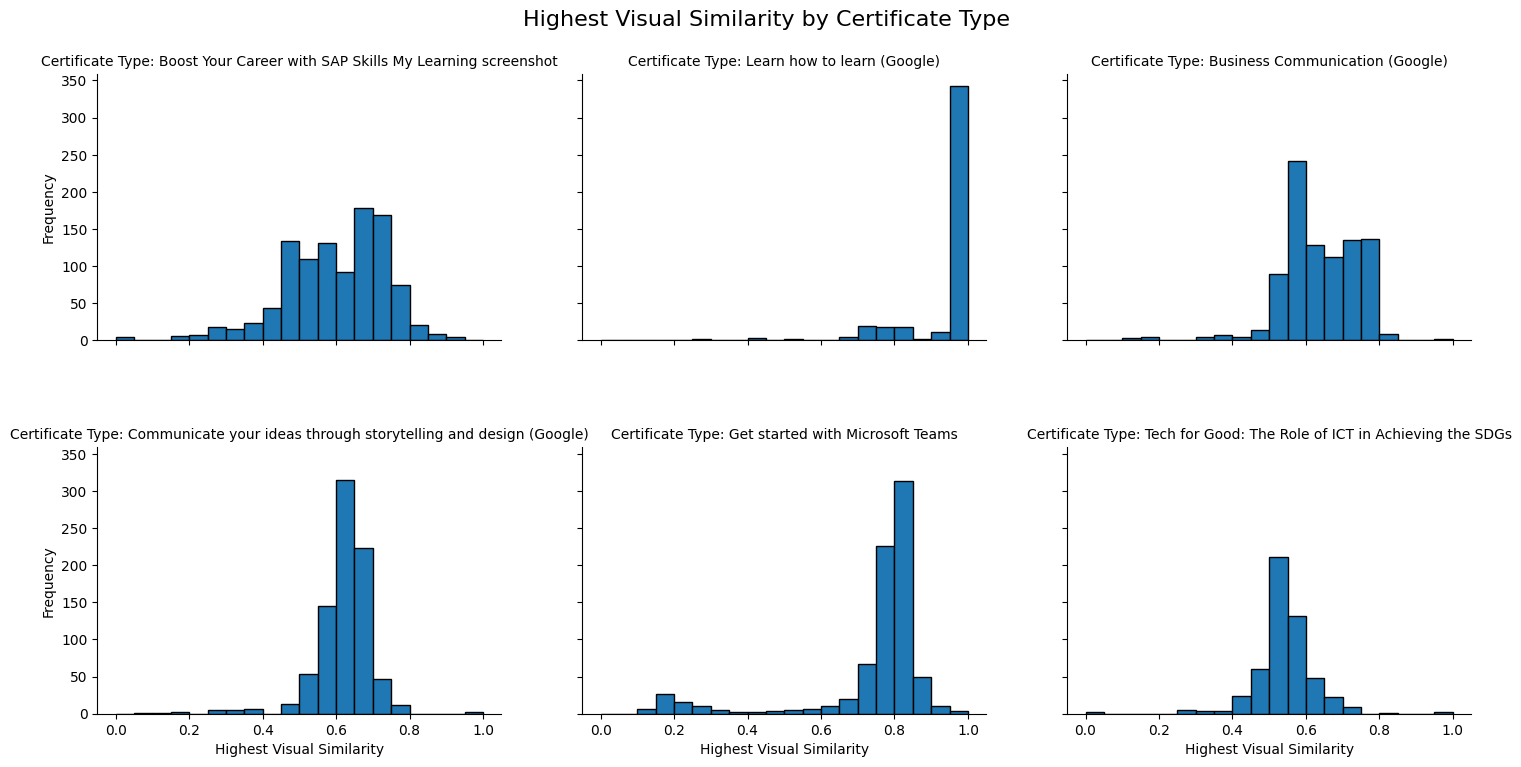

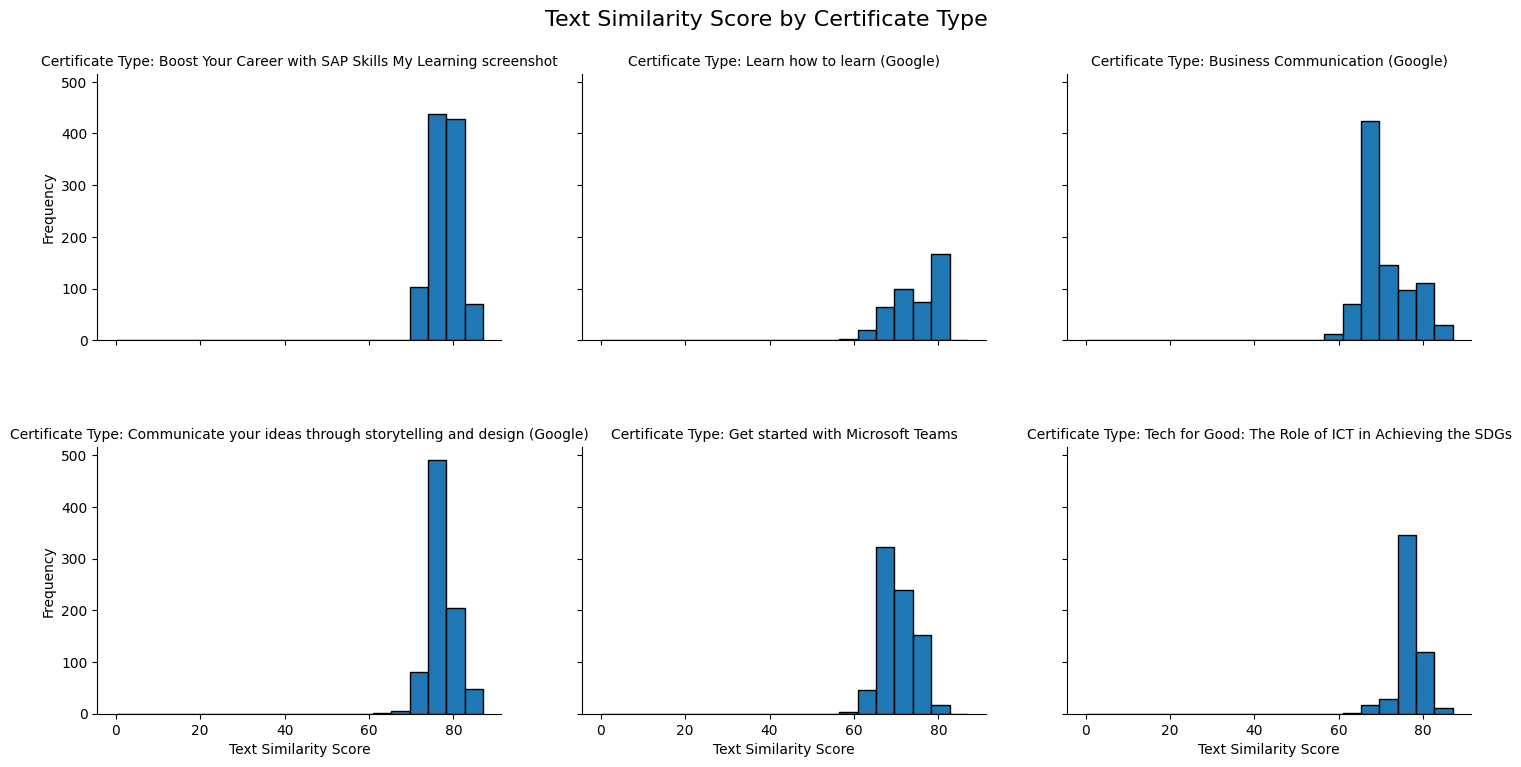

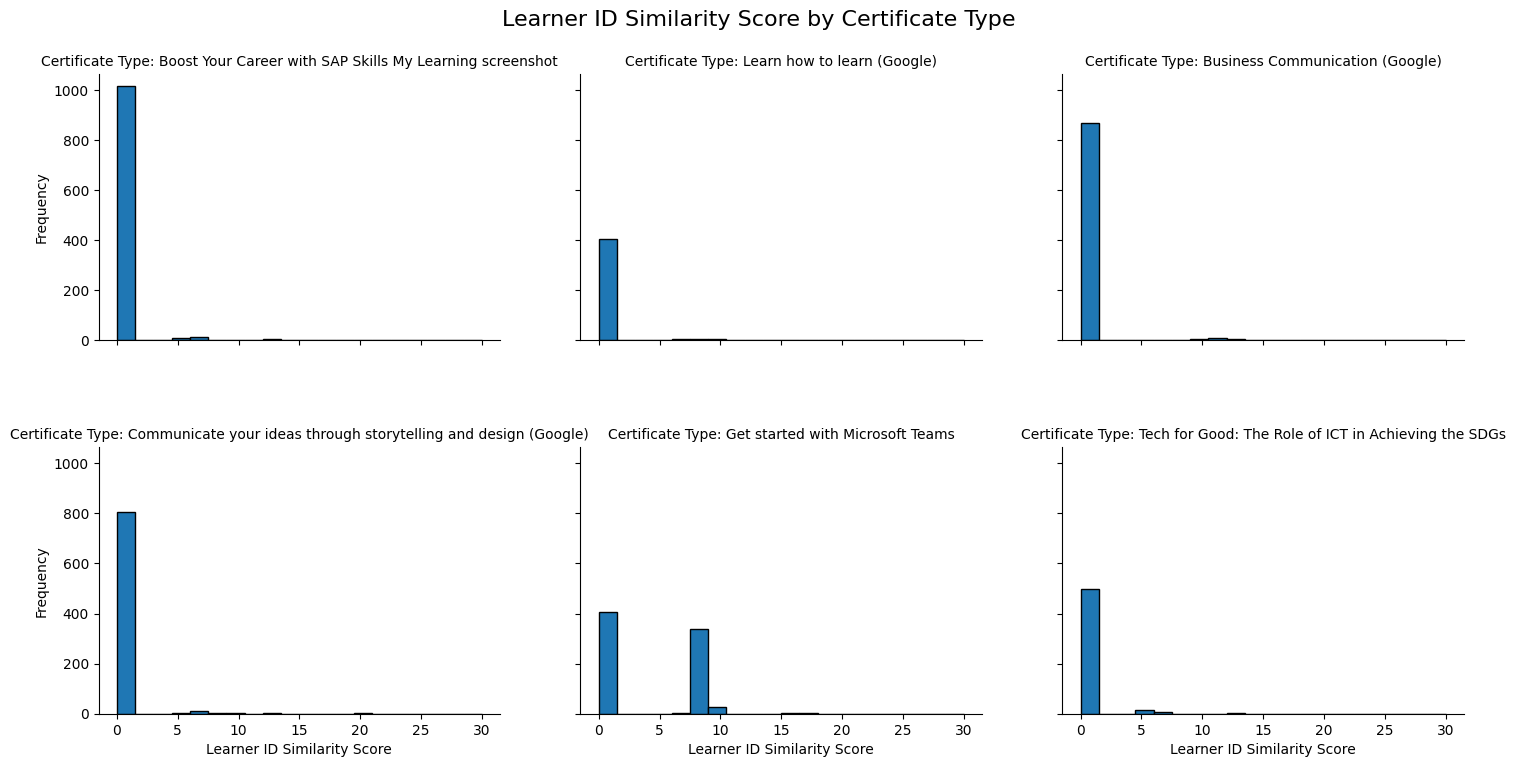

In [302]:
# Check scores

# Columns to analyze
columns_to_analyze = ['Highest Visual Similarity', 'Text Similarity Score', 'Learner ID Similarity Score']

for col in columns_to_analyze:
    filled_df = log_df.fillna({col: 0})
    global_min = filled_df[col].min()
    global_max = filled_df[col].max()

    # Create the grid of subplots
    g = sns.FacetGrid(log_df, col='Certificate Type', col_wrap=3, height=4, aspect=1.2)
    g = (g.map(plt.hist, col, bins=20, edgecolor='black', range=[global_min, global_max])
         .set_axis_labels(col, 'Frequency')
         .set_titles("Certificate Type: {col_name}"))

    # Adjust layout for better spacing
    g.fig.subplots_adjust(top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)
    g.fig.suptitle(f'{col} by Certificate Type', fontsize=16)

    plt.show()


In [303]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Learner ID                   5891 non-null   object 
 1   Certificate Type             5891 non-null   object 
 2   File Name                    5891 non-null   object 
 3   Status                       5891 non-null   object 
 4   Highest Visual Similarity    4495 non-null   float64
 5   Text Similarity Score        4495 non-null   float64
 6   Learner ID Similarity Score  4495 non-null   float64
 7   Errors                       1396 non-null   object 
 8   Extra Info                   906 non-null    object 
dtypes: float64(3), object(6)
memory usage: 414.3+ KB


In [304]:
log_df[['Highest Visual Similarity', 'Text Similarity Score', 'Learner ID Similarity Score']].describe()


,Highest Visual Similarity,Text Similarity Score,Learner ID Similarity Score
count,4495.000000,4495.000000,4495.000000
mean,0.660959,74.652058,0.953404
std,0.160921,5.180494,2.779773
min,0.004756,58.000000,0.000000
25%,0.566596,70.000000,0.000000
50%,0.652431,76.000000,0.000000
75%,0.760028,79.000000,0.000000
max,1.000000,87.000000,30.000000


In [224]:
log_df[log_df['Status'] != 'Success']

,Learner ID,Certificate Type,File Name,Status,Highest Visual Similarity,Text Similarity Score,Learner ID Similarity Score,Errors,Extra Info
6,Emmanuel Adewumi - emmanueladewumig@gmail.com,Business Communication (Google),biz com2.PNG,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
8,Emmanuel Adewumi - emmanueladewumig@gmail.com,Communicate your ideas through storytelling and design (Google),comm_idea.PNG,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
21,Obinna Nwachukwu - nobichukwum@gmail.com,Business Communication (Google),Screenshot (234).png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
23,Obinna Nwachukwu - nobichukwum@gmail.com,Communicate your ideas through storytelling and design (Google),Screenshot (235).png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
34,Adekunle Awotunde - awotundeaadekunle@gmail.com,Business Communication (Google),Screenshot_20231002-192413~2.png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
...,...,...,...,...,...,...,...,...,...
5324,Oladimeji Ibitoye - ibitoye166@gmail.com,Business Communication (Google),Screenshot_20231006-004300.png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
5336,Jardin Egwa - egwajardin@gmail.com,Business Communication (Google),Business communication.png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
5338,Jardin Egwa - egwajardin@gmail.com,Communicate your ideas through storytelling and design (Google),Communicating ideas through story telling.png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"
5353,Jeffrey Nwalima - cjnwalima@gmail.com,Business Communication (Google),Screenshot 2023-10-02 at 11.37.18 PM.png,Failure,NaN,NaN,NaN,An exception occurred: Unsupported file format: . Manual handling required.,"Exception type: Exception, Arguments: ('Unsupported file format: . Manual handling required.',)"


In [305]:
log_df[log_df['Status'] != 'Success']['Errors'].value_counts()

Errors
An exception occurred: Unsupported file format: . Manual handling required.                                                                             870
An exception occurred: Unsupported file format: .docx. Manual handling required.                                                                         12
An exception occurred: Unsupported file format: .html. Manual handling required.                                                                         12
File not found: /Users/gilbert/Downloads/attachments /Learn how to learn (Google)/certs.pdf                                                              12
An exception occurred: Unable to get page count.\nSyntax Error: Document stream is empty\n                                                                4
                                                                                                                                                       ... 
File not found: /Users/gilbert/Downloads/attachments /Get

In [306]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Learner ID                   5891 non-null   object 
 1   Certificate Type             5891 non-null   object 
 2   File Name                    5891 non-null   object 
 3   Status                       5891 non-null   object 
 4   Highest Visual Similarity    4495 non-null   float64
 5   Text Similarity Score        4495 non-null   float64
 6   Learner ID Similarity Score  4495 non-null   float64
 7   Errors                       1396 non-null   object 
 8   Extra Info                   906 non-null    object 
dtypes: float64(3), object(6)
memory usage: 414.3+ KB


In [307]:
# Pivot data

# Group by 'Learner ID' and 'Certificate Type' and take the max value for each group
grouped_df = log_df[['Learner ID', 'Certificate Type', 'Highest Visual Similarity', 'Text Similarity Score', 'Learner ID Similarity Score']].groupby(['Learner ID', 'Certificate Type']).max().reset_index()

# Reshape the DataFrame
pivot_df = pd.pivot_table(grouped_df, index='Learner ID', columns='Certificate Type',
                          values=['Highest Visual Similarity', 'Text Similarity Score', 'Learner ID Similarity Score'],
                          aggfunc='first')

# Flatten the multi-level column names and add custom label
pivot_df.columns = [f"{col[1]}_{col[0]}" for col in pivot_df.columns.values]

# Reset index
pivot_df.reset_index(inplace=True)

# Sort columns
sorted_cols = ['Learner ID'] + sorted([col for col in pivot_df.columns if col != 'Learner ID'])
pivot_df = pivot_df[sorted_cols]

pivot_df

,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Business Communication (Google)_Highest Visual Similarity,Business Communication (Google)_Learner ID Similarity Score,Business Communication (Google)_Text Similarity Score,Communicate your ideas through storytelling and design (Google)_Highest Visual Similarity,Communicate your ideas through storytelling and design (Google)_Learner ID Similarity Score,Communicate your ideas through storytelling and design (Google)_Text Similarity Score,Get started with Microsoft Teams_Highest Visual Similarity,Get started with Microsoft Teams_Learner ID Similarity Score,Get started with Microsoft Teams_Text Similarity Score,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_Text Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity,Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,0.776253,0.0,78.0,0.765831,0.0,68.0,0.661962,0.0,74.0,0.840147,7.69,69.0,0.660241,0.0,69.0,0.594653,0.0,78.0
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0.689502,0.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914979,0.0,73.0,NaN,NaN,NaN
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,0.868088,0.0,79.0,0.751721,0.0,78.0,0.661962,0.0,74.0,0.826227,8.33,69.0,0.975064,0.0,79.0,0.571790,0.0,77.0
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0.845816,0.0,78.0,0.752502,0.0,64.0,NaN,NaN,NaN,0.828439,7.69,69.0,NaN,NaN,NaN,0.721404,0.0,76.0
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,0.745654,0.0,79.0,0.657044,0.0,69.0,0.656458,0.0,78.0,0.874584,8.33,70.0,0.978531,0.0,77.0,1.000000,0.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,ahmed bodunrin - sholabodunrin@gmail.com,0.728367,0.0,76.0,0.789751,0.0,83.0,0.675474,0.0,78.0,0.809351,0.00,77.0,0.976459,0.0,72.0,NaN,NaN,NaN
413,braven munyasia - bravenjuma4@gmail.com,0.709143,0.0,77.0,0.671872,0.0,67.0,0.603011,0.0,75.0,0.888495,8.33,69.0,0.660169,0.0,67.0,NaN,NaN,NaN
414,kennedy okonda - okondaken@gmail.com,0.748830,0.0,79.0,0.738821,0.0,67.0,0.637737,0.0,81.0,0.851731,9.09,69.0,0.975064,0.0,79.0,NaN,NaN,NaN
415,olubunmi akolawole-ajayi - hintyetunde@yahoo.com,0.396752,0.0,78.0,0.442421,0.0,66.0,0.379254,0.0,76.0,0.523330,0.00,70.0,0.449940,0.0,69.0,NaN,NaN,NaN


In [308]:
# Save to a CSV
pivot_df.to_csv("pivot_backup2.csv", index=False)

In [309]:
pivot_df.head()

,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Business Communication (Google)_Highest Visual Similarity,Business Communication (Google)_Learner ID Similarity Score,Business Communication (Google)_Text Similarity Score,Communicate your ideas through storytelling and design (Google)_Highest Visual Similarity,Communicate your ideas through storytelling and design (Google)_Learner ID Similarity Score,Communicate your ideas through storytelling and design (Google)_Text Similarity Score,Get started with Microsoft Teams_Highest Visual Similarity,Get started with Microsoft Teams_Learner ID Similarity Score,Get started with Microsoft Teams_Text Similarity Score,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_Text Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity,Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,0.776253,0.0,78.0,0.765831,0.0,68.0,0.661962,0.0,74.0,0.840147,7.69,69.0,0.660241,0.0,69.0,0.594653,0.0,78.0
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0.689502,0.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914979,0.0,73.0,NaN,NaN,NaN
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,0.868088,0.0,79.0,0.751721,0.0,78.0,0.661962,0.0,74.0,0.826227,8.33,69.0,0.975064,0.0,79.0,0.571790,0.0,77.0
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0.845816,0.0,78.0,0.752502,0.0,64.0,NaN,NaN,NaN,0.828439,7.69,69.0,NaN,NaN,NaN,0.721404,0.0,76.0
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,0.745654,0.0,79.0,0.657044,0.0,69.0,0.656458,0.0,78.0,0.874584,8.33,70.0,0.978531,0.0,77.0,1.000000,0.0,77.0


In [310]:
pivot_df.describe()

,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Business Communication (Google)_Highest Visual Similarity,Business Communication (Google)_Learner ID Similarity Score,Business Communication (Google)_Text Similarity Score,Communicate your ideas through storytelling and design (Google)_Highest Visual Similarity,Communicate your ideas through storytelling and design (Google)_Learner ID Similarity Score,Communicate your ideas through storytelling and design (Google)_Text Similarity Score,Get started with Microsoft Teams_Highest Visual Similarity,Get started with Microsoft Teams_Learner ID Similarity Score,Get started with Microsoft Teams_Text Similarity Score,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_Text Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity,Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score
count,414.000000,414.000000,414.000000,395.000000,395.000000,395.000000,376.000000,376.000000,376.000000,334.000000,334.000000,334.000000,404.000000,404.000000,404.000000,183.000000,183.000000,183.000000
mean,0.702497,0.161812,78.601449,0.714638,0.399013,71.427848,0.645980,0.294840,77.452128,0.783770,4.360749,71.218563,0.937691,0.502500,74.636139,0.590878,0.498197,77.207650
std,0.104618,1.134222,3.034602,0.082662,2.376929,5.737200,0.071859,1.717748,3.304598,0.159503,4.262956,3.920013,0.108709,2.178346,4.891760,0.091650,1.930669,3.511449
min,0.039155,0.000000,70.000000,0.103552,0.000000,58.000000,0.110617,0.000000,66.000000,0.136198,0.000000,60.000000,0.293212,0.000000,59.000000,0.006792,0.000000,64.000000
25%,0.686314,0.000000,77.000000,0.684956,0.000000,68.000000,0.614976,0.000000,76.000000,0.804486,0.000000,69.000000,0.973424,0.000000,71.000000,0.554208,0.000000,76.000000
50%,0.707742,0.000000,79.000000,0.726814,0.000000,69.000000,0.649315,0.000000,77.000000,0.825728,7.690000,70.000000,0.975064,0.000000,77.000000,0.587475,0.000000,77.000000
75%,0.750119,0.000000,81.000000,0.758604,0.000000,76.000000,0.687204,0.000000,80.000000,0.836769,8.330000,74.000000,0.978531,0.000000,79.000000,0.625250,0.000000,80.000000
max,1.000000,13.330000,85.000000,1.000000,30.000000,84.000000,1.000000,20.000000,87.000000,1.000000,16.670000,82.000000,1.000000,15.380000,80.000000,1.000000,13.330000,85.000000


In [312]:
# Calculate thresholds for accepting / rejecting certificates

# Initialize an empty DataFrame
calculated_thresholds_df = pd.DataFrame(columns=['Certificate Type', 'Visual_Threshold_Percentile', 'Visual_Threshold_Zscore', 'Text_Threshold_Percentile', 'Text_Threshold_Zscore', 'Learner_ID_Threshold_Percentile', 'Learner_ID_Threshold_Zscore'])

# Loop through each certificate type to calculate thresholds
for cert_type in certificate_names:
    visual_data = pivot_df[f"{cert_type}_Highest Visual Similarity"].dropna()
    text_data = pivot_df[f"{cert_type}_Text Similarity Score"].dropna()
    learner_id_data = pivot_df[f"{cert_type}_Learner ID Similarity Score"].dropna()

    # Calculate Percentile
    visual_threshold_percentile = visual_data.quantile(percentile_factor)
    text_threshold_percentile = text_data.quantile(percentile_factor)
    learner_id_threshold_percentile = learner_id_data.quantile(percentile_factor)

    # Calculate Z-score thresholds
    visual_threshold_zscore = visual_data.mean() + z_score_factor * visual_data.std()
    text_threshold_zscore = text_data.mean() + z_score_factor * text_data.std()
    learner_id_threshold_zscore = learner_id_data.mean() + z_score_factor * learner_id_data.std()

    # Create a DataFrame for the current certificate type
    temp_df = pd.DataFrame({
        'Certificate Type': [cert_type],
        'Visual_Threshold_Percentile': [visual_threshold_percentile],
        'Visual_Threshold_Zscore': [visual_threshold_zscore],
        'Text_Threshold_Percentile': [text_threshold_percentile],
        'Text_Threshold_Zscore': [text_threshold_zscore],
        'Learner_ID_Threshold_Percentile': [learner_id_threshold_percentile],
        'Learner_ID_Threshold_Zscore': [learner_id_threshold_zscore]
    })

    # Concatenate to the existing DataFrame
    calculated_thresholds_df = pd.concat([calculated_thresholds_df, temp_df], ignore_index=True)

# Show the DataFrame with calculated thresholds
calculated_thresholds_df




/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/4283844617.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calculated_thresholds_df = pd.concat([calculated_thresholds_df, temp_df], ignore_index=True)


,Certificate Type,Visual_Threshold_Percentile,Visual_Threshold_Zscore,Text_Threshold_Percentile,Text_Threshold_Zscore,Learner_ID_Threshold_Percentile,Learner_ID_Threshold_Zscore
0,Boost Your Career with SAP Skills My Learning screenshot,0.631050,0.530400,74.0,73.609528,0.0,-1.703984
1,Learn how to learn (Google),0.791449,0.758864,68.0,66.589194,0.0,-3.080880
2,Business Communication (Google),0.642931,0.578660,66.0,61.990154,0.0,-3.511036
3,Communicate your ideas through storytelling and design (Google),0.575560,0.527772,74.0,72.016064,0.0,-2.530854
4,Get started with Microsoft Teams,0.722670,0.521388,68.0,64.770142,0.0,-2.651814
5,Tech for Good: The Role of ICT in Achieving the SDGs,0.522640,0.440114,73.0,71.431317,0.0,-2.677754


In [313]:
# Initialize an empty dictionary to store dynamic thresholds
thresholds = {}

# Loop through the DataFrame to populate the thresholds dictionary
for index, row in calculated_thresholds_df.iterrows():
    cert_type = row['Certificate Type']

    thresholds[cert_type] = {
        'visual': row['Visual_Threshold_Percentile'],  # Replace with row['Visual_Threshold_Zscore'] if you want to use Z-score
        'text': row['Text_Threshold_Percentile'],  # Replace with row['Text_Threshold_Zscore'] if you want to use Z-score
        'learner_id': row['Learner_ID_Threshold_Percentile']  # Replace with row['Learner_ID_Threshold_Zscore'] if you want to use Z-score
    }

# Now the thresholds dictionary is dynamically populated based on calculated_thresholds_df
thresholds


{'Boost Your Career with SAP Skills My Learning screenshot': {'visual': 0.6310500554936557,
  'text': 74.0,
  'learner_id': 0.0},
 'Learn how to learn (Google)': {'visual': 0.79144860244974,
  'text': 68.0,
  'learner_id': 0.0},
 'Business Communication (Google)': {'visual': 0.642930900085002,
  'text': 66.0,
  'learner_id': 0.0},
 'Communicate your ideas through storytelling and design (Google)': {'visual': 0.5755599876683408,
  'text': 74.0,
  'learner_id': 0.0},
 'Get started with Microsoft Teams': {'visual': 0.7226702988786304,
  'text': 68.0,
  'learner_id': 0.0},
 'Tech for Good: The Role of ICT in Achieving the SDGs': {'visual': 0.5226401437729999,
  'text': 73.0,
  'learner_id': 0.0}}

In [314]:
# Manually input thresholds
thresholds = {
'Boost Your Career with SAP Skills My Learning screenshot': {'visual': 0.50,'text': 50.0,'learner_id': 0.0},
'Learn how to learn (Google)': {'visual': 0.50,'text': 50.0,'learner_id': 0.0},
'Business Communication (Google)': {'visual': 0.50,'text': 50.0,'learner_id': 0.0},
'Communicate your ideas through storytelling and design (Google)': {'visual': 0.50,'text': 50.0, 'learner_id': 0.0},
'Get started with Microsoft Teams': {'visual': 0.50,'text': 50.0,'learner_id': 0.0},
'Tech for Good: The Role of ICT in Achieving the SDGs': {'visual': 0.45,'text': 50.0,'learner_id': 0.0}
}

In [315]:
# Evaluate images based on thresholds

# Create new columns based on certificate-specific thresholds and reasons for rejection
for cert_type in thresholds.keys():
    visual_threshold = thresholds[cert_type]['visual']
    text_threshold = thresholds[cert_type]['text']
    learner_id_threshold = thresholds[cert_type]['learner_id']

    col_suffix = f"{cert_type}_AcceptOrReject"
    reason_suffix = f"{cert_type}_RejectionReasons"

    # Create a series with rejection reasons
    def find_rejection_reasons(row):
        reasons = []
        if row.get(f"{cert_type}_Highest Visual Similarity", 0) < visual_threshold:
            reasons.append('Visual')
        if row.get(f"{cert_type}_Text Similarity Score", 0) < text_threshold:
            reasons.append('Text')
        if row.get(f"{cert_type}_Learner ID Similarity Score", 0) < learner_id_threshold:
            reasons.append('ID')
        return reasons

    # Create the AcceptOrReject and RejectionReasons columns
    pivot_df.loc[:, col_suffix] = (
        (pivot_df.get(f"{cert_type}_Highest Visual Similarity", 0) >= visual_threshold) &
        (pivot_df.get(f"{cert_type}_Text Similarity Score", 0) >= text_threshold) &
        (pivot_df.get(f"{cert_type}_Learner ID Similarity Score", 0) >= learner_id_threshold)
    ).astype(int)

    pivot_df[reason_suffix] = pivot_df.apply(find_rejection_reasons, axis=1)

# Initialize an empty list to store the new order of columns
new_column_order = ['Learner ID']  # Start with 'Learner ID'

# Loop through each certificate type and arrange the columns
for cert_type in thresholds.keys():
    new_column_order.extend([
        f"{cert_type}_Highest Visual Similarity",
        f"{cert_type}_Text Similarity Score",
        f"{cert_type}_Learner ID Similarity Score",
        f"{cert_type}_AcceptOrReject",
        f"{cert_type}_RejectionReasons"  # Include the new RejectionReasons column
    ])

# Reorder the DataFrame columns based on the new list
pivot_df = pivot_df[new_column_order]

# Show the DataFrame with reordered columns
pivot_df


,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Text Similarity Score,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_AcceptOrReject,...,Get started with Microsoft Teams_Highest Visual Similarity,Get started with Microsoft Teams_Text Similarity Score,Get started with Microsoft Teams_Learner ID Similarity Score,Get started with Microsoft Teams_AcceptOrReject,Get started with Microsoft Teams_RejectionReasons,Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity,Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_AcceptOrReject,Tech for Good: The Role of ICT in Achieving the SDGs_RejectionReasons
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,0.776253,78.0,0.0,1,[],0.660241,69.0,0.0,1,...,0.840147,69.0,7.69,1,[],0.594653,78.0,0.0,1,[]
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0.689502,78.0,0.0,1,[],0.914979,73.0,0.0,1,...,NaN,NaN,NaN,0,[],NaN,NaN,NaN,0,[]
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,0.868088,79.0,0.0,1,[],0.975064,79.0,0.0,1,...,0.826227,69.0,8.33,1,[],0.571790,77.0,0.0,1,[]
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0.845816,78.0,0.0,1,[],NaN,NaN,NaN,0,...,0.828439,69.0,7.69,1,[],0.721404,76.0,0.0,1,[]
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,0.745654,79.0,0.0,1,[],0.978531,77.0,0.0,1,...,0.874584,70.0,8.33,1,[],1.000000,77.0,0.0,1,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,ahmed bodunrin - sholabodunrin@gmail.com,0.728367,76.0,0.0,1,[],0.976459,72.0,0.0,1,...,0.809351,77.0,0.00,1,[],NaN,NaN,NaN,0,[]
413,braven munyasia - bravenjuma4@gmail.com,0.709143,77.0,0.0,1,[],0.660169,67.0,0.0,1,...,0.888495,69.0,8.33,1,[],NaN,NaN,NaN,0,[]
414,kennedy okonda - okondaken@gmail.com,0.748830,79.0,0.0,1,[],0.975064,79.0,0.0,1,...,0.851731,69.0,9.09,1,[],NaN,NaN,NaN,0,[]
415,olubunmi akolawole-ajayi - hintyetunde@yahoo.com,0.396752,78.0,0.0,0,[Visual],0.449940,69.0,0.0,0,...,0.523330,70.0,0.00,1,[],NaN,NaN,NaN,0,[]


In [316]:
# Extract all columns that contain "AcceptOrReject"
accept_or_reject_cols = [col for col in pivot_df.columns if "AcceptOrReject" in col]

# Compute the minimum value along the rows for the AcceptOrReject columns
minimums = pivot_df[accept_or_reject_cols].min(axis=1)

# Create the 'Learner Status' column
# If minimum is 0, set 'Learner Status' to 0, else set to 1
pivot_df['Learner Status'] = (minimums != 0).astype(int)

# View the updated DataFrame
pivot_df[['Learner ID','Learner Status'] + accept_or_reject_cols]


/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/3418093927.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df['Learner Status'] = (minimums != 0).astype(int)


,Learner ID,Learner Status,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Learn how to learn (Google)_AcceptOrReject,Business Communication (Google)_AcceptOrReject,Communicate your ideas through storytelling and design (Google)_AcceptOrReject,Get started with Microsoft Teams_AcceptOrReject,Tech for Good: The Role of ICT in Achieving the SDGs_AcceptOrReject
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,1,1,1,1,1,1,1
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0,1,1,0,0,0,0
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,1,1,1,1,1,1,1
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0,1,0,1,0,1,1
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
412,ahmed bodunrin - sholabodunrin@gmail.com,0,1,1,1,1,1,0
413,braven munyasia - bravenjuma4@gmail.com,0,1,1,1,1,1,0
414,kennedy okonda - okondaken@gmail.com,0,1,1,1,1,1,0
415,olubunmi akolawole-ajayi - hintyetunde@yahoo.com,0,0,0,0,0,1,0


In [317]:
# Add an explanation by identifying which certificates were rejected

# Extract all columns that contain "AcceptOrReject"
accept_or_reject_cols = [col for col in pivot_df.columns if "AcceptOrReject" in col]

# Compute the minimum value along the rows for the AcceptOrReject columns
minimums = pivot_df[accept_or_reject_cols].min(axis=1)

# Create the 'Learner Status' column
# If minimum is 0, set 'Learner Status' to 0, else set to 1
pivot_df['Learner Status'] = (minimums != 0).astype(int)

# Create a new column to store the names of the AcceptOrReject columns that have 0 values
def find_zero_cols(row):
    zero_cols = [col.replace("_AcceptOrReject", "") for col in accept_or_reject_cols if row[col] == 0]
    return zero_cols  # Returning a list instead of a string

pivot_df['Rejected Certificates'] = pivot_df.apply(find_zero_cols, axis=1)

# View the updated DataFrame
pivot_df[['Learner ID', 'Learner Status', 'Rejected Certificates'] + accept_or_reject_cols]

/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/3968214438.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df['Learner Status'] = (minimums != 0).astype(int)
/var/folders/qr/3v4h7s891cq8wwwvbg_w7y8c0000gn/T/ipykernel_1223/3968214438.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df['Rejected Certificates'] = pivot_df.apply(find_zero_cols, axis=1)


,Learner ID,Learner Status,Rejected Certificates,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Learn how to learn (Google)_AcceptOrReject,Business Communication (Google)_AcceptOrReject,Communicate your ideas through storytelling and design (Google)_AcceptOrReject,Get started with Microsoft Teams_AcceptOrReject,Tech for Good: The Role of ICT in Achieving the SDGs_AcceptOrReject
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,1,[],1,1,1,1,1,1
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0,"[Business Communication (Google), Communicate your ideas through storytelling and design (Google), Get started with Microsoft Teams, Tech for Good: The Role of ICT in Achieving the SDGs]",1,1,0,0,0,0
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,1,[],1,1,1,1,1,1
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0,"[Learn how to learn (Google), Communicate your ideas through storytelling and design (Google)]",1,0,1,0,1,1
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,1,[],1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
412,ahmed bodunrin - sholabodunrin@gmail.com,0,[Tech for Good: The Role of ICT in Achieving the SDGs],1,1,1,1,1,0
413,braven munyasia - bravenjuma4@gmail.com,0,[Tech for Good: The Role of ICT in Achieving the SDGs],1,1,1,1,1,0
414,kennedy okonda - okondaken@gmail.com,0,[Tech for Good: The Role of ICT in Achieving the SDGs],1,1,1,1,1,0
415,olubunmi akolawole-ajayi - hintyetunde@yahoo.com,0,"[Boost Your Career with SAP Skills My Learning screenshot, Learn how to learn (Google), Business Communication (Google), Communicate your ideas through storytelling and design (Google), Tech for Good: The Role of ICT in Achieving the SDGs]",0,0,0,0,1,0


In [318]:
pivot_df[pivot_df['Learner Status']==0]

,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Text Similarity Score,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_AcceptOrReject,...,Get started with Microsoft Teams_Learner ID Similarity Score,Get started with Microsoft Teams_AcceptOrReject,Get started with Microsoft Teams_RejectionReasons,Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity,Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_AcceptOrReject,Tech for Good: The Role of ICT in Achieving the SDGs_RejectionReasons,Learner Status,Rejected Certificates
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0.689502,78.0,0.0,1,[],0.914979,73.0,0.0,1,...,NaN,0,[],NaN,NaN,NaN,0,[],0,"[Business Communication (Google), Communicate your ideas through storytelling and design (Google), Get started with Microsoft Teams, Tech for Good: The Role of ICT in Achieving the SDGs]"
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0.845816,78.0,0.0,1,[],NaN,NaN,NaN,0,...,7.69,1,[],0.721404,76.0,0.0,1,[],0,"[Learn how to learn (Google), Communicate your ideas through storytelling and design (Google)]"
6,Abdulhafiz Zubairu - zubamsabdul@gmail.com,0.816094,83.0,0.0,1,[],0.716551,75.0,0.0,1,...,8.33,1,[],NaN,NaN,NaN,0,[],0,[Tech for Good: The Role of ICT in Achieving the SDGs]
7,Abdulhakeem Shaibu - alhak.peace4u@gmail.com,0.424535,77.0,0.0,0,[Visual],0.790087,69.0,0.0,1,...,0.00,1,[],0.692096,77.0,0.0,1,[],0,[Boost Your Career with SAP Skills My Learning screenshot]
9,Abdulkabir Jimoh - jferanmi24@gmail.com,0.571654,73.0,0.0,1,[],0.975064,79.0,0.0,1,...,0.00,0,[Visual],NaN,NaN,NaN,0,[],0,"[Get started with Microsoft Teams, Tech for Good: The Role of ICT in Achieving the SDGs]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,ahmed bodunrin - sholabodunrin@gmail.com,0.728367,76.0,0.0,1,[],0.976459,72.0,0.0,1,...,0.00,1,[],NaN,NaN,NaN,0,[],0,[Tech for Good: The Role of ICT in Achieving the SDGs]
413,braven munyasia - bravenjuma4@gmail.com,0.709143,77.0,0.0,1,[],0.660169,67.0,0.0,1,...,8.33,1,[],NaN,NaN,NaN,0,[],0,[Tech for Good: The Role of ICT in Achieving the SDGs]
414,kennedy okonda - okondaken@gmail.com,0.748830,79.0,0.0,1,[],0.975064,79.0,0.0,1,...,9.09,1,[],NaN,NaN,NaN,0,[],0,[Tech for Good: The Role of ICT in Achieving the SDGs]
415,olubunmi akolawole-ajayi - hintyetunde@yahoo.com,0.396752,78.0,0.0,0,[Visual],0.449940,69.0,0.0,0,...,0.00,1,[],NaN,NaN,NaN,0,[],0,"[Boost Your Career with SAP Skills My Learning screenshot, Learn how to learn (Google), Business Communication (Google), Communicate your ideas through storytelling and design (Google), Tech for Good: The Role of ICT in Achieving the SDGs]"


In [319]:
pivot_df[pivot_df['Learner Status']==0].count()

Learner ID                                                                                     267
Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity             264
Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score                 264
Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score           264
Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject                        267
Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons                      267
Learn how to learn (Google)_Highest Visual Similarity                                          254
Learn how to learn (Google)_Text Similarity Score                                              254
Learn how to learn (Google)_Learner ID Similarity Score                                        254
Learn how to learn (Google)_AcceptOrReject                                                     267
Learn how 

In [320]:
pivot_df.head()

,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Text Similarity Score,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_AcceptOrReject,...,Get started with Microsoft Teams_Learner ID Similarity Score,Get started with Microsoft Teams_AcceptOrReject,Get started with Microsoft Teams_RejectionReasons,Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity,Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score,Tech for Good: The Role of ICT in Achieving the SDGs_AcceptOrReject,Tech for Good: The Role of ICT in Achieving the SDGs_RejectionReasons,Learner Status,Rejected Certificates
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,0.776253,78.0,0.0,1,[],0.660241,69.0,0.0,1,...,7.69,1,[],0.594653,78.0,0.0,1,[],1,[]
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0.689502,78.0,0.0,1,[],0.914979,73.0,0.0,1,...,NaN,0,[],NaN,NaN,NaN,0,[],0,"[Business Communication (Google), Communicate your ideas through storytelling and design (Google), Get started with Microsoft Teams, Tech for Good: The Role of ICT in Achieving the SDGs]"
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,0.868088,79.0,0.0,1,[],0.975064,79.0,0.0,1,...,8.33,1,[],0.571790,77.0,0.0,1,[],1,[]
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0.845816,78.0,0.0,1,[],NaN,NaN,NaN,0,...,7.69,1,[],0.721404,76.0,0.0,1,[],0,"[Learn how to learn (Google), Communicate your ideas through storytelling and design (Google)]"
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,0.745654,79.0,0.0,1,[],0.978531,77.0,0.0,1,...,8.33,1,[],1.000000,77.0,0.0,1,[],1,[]


In [321]:
# Merge pivot_df and df_learners_selected to compare scores with screenshots

# Merge pivot_df and df_learners_selected based on 'Learner ID', keeping only the rows in pivot_df
df_learners_evaluated = pd.merge(pivot_df, df_learners_selected, on='Learner ID', how='left')

# Show the resulting DataFrame
df_learners_evaluated


,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Text Similarity Score,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_AcceptOrReject,...,Email address,First Name,Last name,Block 1 progress %,Boost Your Career with SAP Skills My Learning screenshot,Learn how to learn (Google),Business Communication (Google),Communicate your ideas through storytelling and design (Google),Get started with Microsoft Teams,Tech for Good: The Role of ICT in Achieving the SDGs
0,ABDULAZEEZ OTU - abdulazeez.oe@gmail.com,0.776253,78.0,0.0,1,[],0.660241,69.0,0.0,1,...,abdulazeez.oe@gmail.com,ABDULAZEEZ,OTU,1.0,[Screenshot_20230913-232240_1.png],[Screenshot_20231002-201541.png],[Screenshot_20231002-185251_1.png],[Communicate your ideas through storytelling and design _ Google.pdf],[Transcript - AbdulazeezOtu-2553 _ Microsoft Learn (1).pdf],[1696538720716_edx.jpg]
1,ADEJO SUNDAY - meetemmanueles@gmail.com,0.689502,78.0,0.0,1,[],0.914979,73.0,0.0,1,...,meetemmanueles@gmail.com,ADEJO,SUNDAY,0.2,[Screenshot (My Learning Page).png],"[CONNECT AND COLLABORATE FROM ANYWHERE WITH DIGITAL TOOLS.pdf, Create a Collaborative Study Guide.pdf, Create A Schedule to Meet Your Goals.pdf, CREATE AN ANOTATED PLAYLIST.pdf, Learn New Vocabulary with Flash Cards.pdf, MEMORIZE FACTS WITH A VISUAL MNEMONIC.pdf, Take Notes in a Table.pdf]",NaN,NaN,NaN,NaN
2,AHMAD BASHIRU - ahmadbash200inumaitumbi@gmail.com,0.868088,79.0,0.0,1,[],0.975064,79.0,0.0,1,...,ahmadbash200inumaitumbi@gmail.com,AHMAD,BASHIRU,1.0,[Screenshot_20230913-212244.png],[certs.pdf],[Business Communication _ Google.pdf],[Communicate your ideas through storytelling and design _ Google.pdf],[Transcript - ahmadbashir-7361 _ Microsoft Learn.pdf],[Screenshot_20231002-110503.png]
3,AYOTUNDE BELLO AYOTUNDE LUKMAN - bellotunde87@gmail.com,0.845816,78.0,0.0,1,[],NaN,NaN,NaN,0,...,bellotunde87@gmail.com,AYOTUNDE,BELLO AYOTUNDE LUKMAN,1.0,[AYO FIRST TASK.pdf],[AYOS COMMUNICATE EFFECTIVELY AT WORK 1.pdf],[BUSINESS COMMUNICATION.pdf],[COMMUNICATE IDEAS THROUGH STORY TELLING.pdf],[Transcript - ayotundebello-6746 _ Microsoft Learn.pdf],[AYO's ICT FOR GOOD.pdf]
4,Abayomi Azeez - abayomiazeez0903403@yahoo.com,0.745654,79.0,0.0,1,[],0.978531,77.0,0.0,1,...,abayomiazeez0903403@yahoo.com,Abayomi,Azeez,1.0,[Screenshot_20230923-151659.png],[certs (3).pdf],[Screenshot_20231005-100356.png],[Screenshot_20231005-104804.png],[Transcript - abayomiazeez-9362 _ Microsoft Learn.pdf],[Screenshot_20231006-173657.png]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,ahmed bodunrin - sholabodunrin@gmail.com,0.728367,76.0,0.0,1,[],0.976459,72.0,0.0,1,...,sholabodunrin@gmail.com,ahmed,bodunrin,1.0,[Screenshot_2023-09-16-22-00-56-805.jpg],[Communicate Effectively Cert.pdf],[Business Communication.png],[Communicate Your Ideas cert.png],[Collabrating With Teams.pdf],[Tech for Good cert.png]
413,braven munyasia - bravenjuma4@gmail.com,0.709143,77.0,0.0,1,[],0.660169,67.0,0.0,1,...,bravenjuma4@gmail.com,braven,munyasia,0.8,"[Screenshot_20230915_114304_Chrome.jpg, Screenshot_20230915_114716_Chrome.jpg]",[Screenshot_20231003_185509_Chrome.jpg],[Screenshot_20231003_185306_Chrome.jpg],"[IMG-20231004-WA0001.jpg, IMG-20231004-WA0000.jpg]",[Transcript - bravenmunyasia-7129 _ Microsoft Learn.pdf],NaN
414,kennedy okonda - okondaken@gmail.com,0.748830,79.0,0.0,1,[],0.975064,79.0,0.0,1,...,okondaken@gmail.com,kennedy,okonda,1.0,[Screenshot_20230918-191042.png],[certs.pdf],[Screenshot from 2023-10-03 01-23-49.png],[k.png],[Transcript - kennedyokonda-9563 Micro

In [322]:
df_learners_evaluated.columns

Index(['Learner ID',
       'Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity',
       'Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score',
       'Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score',
       'Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject',
       'Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons',
       'Learn how to learn (Google)_Highest Visual Similarity',
       'Learn how to learn (Google)_Text Similarity Score',
       'Learn how to learn (Google)_Learner ID Similarity Score',
       'Learn how to learn (Google)_AcceptOrReject',
       'Learn how to learn (Google)_RejectionReasons',
       'Business Communication (Google)_Highest Visual Similarity',
       'Business Communication (Google)_Text Similarity Score',
       'Business Communication (Google)_Learner ID Similarity Score',
       'Business Communication (Goog

In [325]:
df_learners_evaluated.to_csv('/Users/gilbert/Downloads/learners_evaluated_2.csv', index=False)

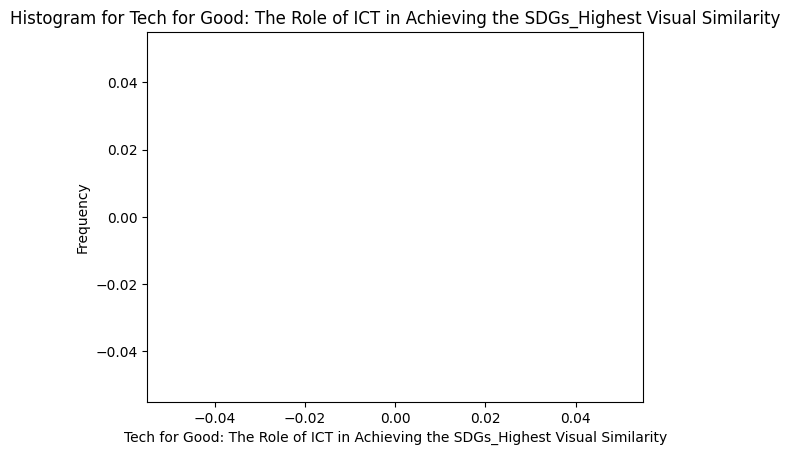

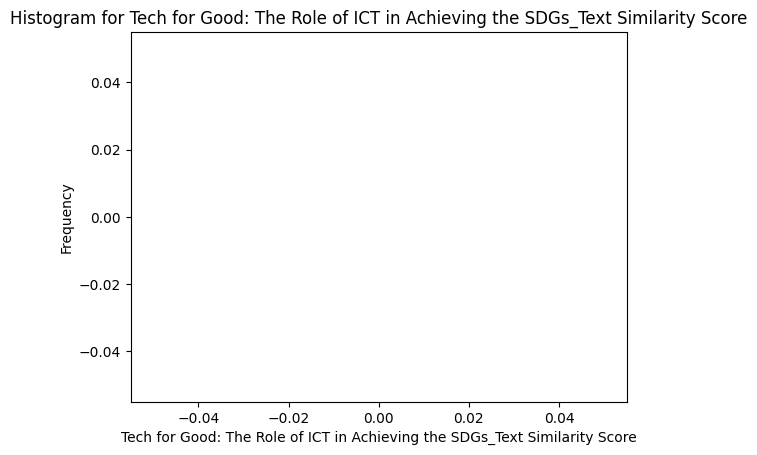

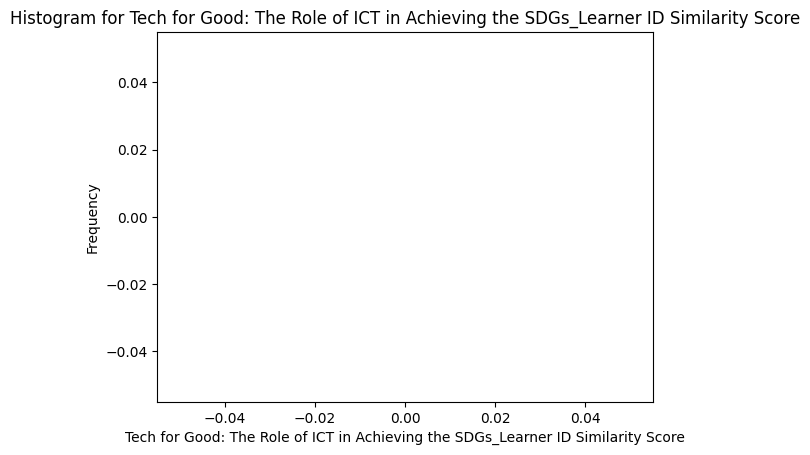

In [244]:
# Inspect failed learners with histograms

# Filter the DataFrame where 'Learner Status' equals 0
filtered_df = df_learners_evaluated[
    (df_learners_evaluated['Learner Status'] == 0) &
    (df_learners_evaluated['Rejected Certificates'] == 'Tech for Good: The Role of ICT in Achieving the SDGs')
]

# Columns to create histograms for
columns_to_plot = [
    'Tech for Good: The Role of ICT in Achieving the SDGs_Highest Visual Similarity',
    'Tech for Good: The Role of ICT in Achieving the SDGs_Text Similarity Score',
    'Tech for Good: The Role of ICT in Achieving the SDGs_Learner ID Similarity Score'
]

# Create histograms
for col in columns_to_plot:
    sns.histplot(filtered_df[col], kde=False, bins=30)  # You can customize bins and other style options here
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [261]:
print(df_learners_evaluated[df_learners_evaluated['Learner Status'] == 0]['Rejected Certificates'])

1                                                                                             [Business Communication (Google), Communicate your ideas through storytelling and design (Google), Get started with Microsoft Teams, Tech for Good: The Role of ICT in Achieving the SDGs]
3                                                                                                                                                                                         [Learn how to learn (Google), Communicate your ideas through storytelling and design (Google)]
6                                                                                                                                                                                                                                 [Tech for Good: The Role of ICT in Achieving the SDGs]
7                                                                                                                                                            

In [263]:
df_learners_evaluated[(df_learners_evaluated['Learner Status'] == 0) & df_learners_evaluated['Rejected Certificates'].isna()]


,Learner ID,Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity,Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score,Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject,Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons,Learn how to learn (Google)_Highest Visual Similarity,Learn how to learn (Google)_Text Similarity Score,Learn how to learn (Google)_Learner ID Similarity Score,Learn how to learn (Google)_AcceptOrReject,...,Email address,First Name,Last name,Block 1 progress %,Boost Your Career with SAP Skills My Learning screenshot,Learn how to learn (Google),Business Communication (Google),Communicate your ideas through storytelling and design (Google),Get started with Microsoft Teams,Tech for Good: The Role of ICT in Achieving the SDGs


In [268]:
# Retrieve learner screenshots to inspect by cert type

import math

destination_base_folder = '/Users/gilbert/Downloads/check_temp'

if not os.path.exists(destination_base_folder):
    os.makedirs(destination_base_folder)

for index, row in df_learners_evaluated.iterrows():
    if row['Learner Status'] == 0:
        learner_id = row['Learner ID']
        rejected_certs = row['Rejected Certificates']
        
        for cert_col in rejected_certs:
            destination_folder = os.path.join(destination_base_folder, cert_col)
            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)

            cert_names = row[cert_col]
            if not isinstance(cert_names, list):
                cert_names = [certificate_names]

                print(f"cert_names before loop: {cert_names}")

                for cert_name in cert_names:

                    if cert_name is None or (isinstance(cert_name, float) and math.isnan(cert_name)):
                        print(f"Skipping invalid cert_name: {cert_name}")
                        continue
        
                    source_folder = f"/Users/gilbert/Downloads/content/attachments/{cert_col}"
                    source_file_path = os.path.join(source_folder, str(cert_name))  # Convert to str just in case

                    print(f"Checking existence of {source_file_path}")  # Debug print
                    
                    if os.path.exists(source_file_path):
                        file_extension = os.path.splitext(cert_name)[1]
                        new_file_name = f"{learner_id}{file_extension}"
                        destination_file_path = os.path.join(destination_folder, new_file_name)
    
                        print(f"Copying {source_file_path} to {destination_file_path}")  # Debug print
    
                        shutil.copy(source_file_path, destination_file_path)
                    else:
                        print(f"File {source_file_path} does not exist.")  # Debug print

cert_names before loop: [['Boost Your Career with SAP Skills My Learning screenshot', 'Learn how to learn (Google)', 'Business Communication (Google)', 'Communicate your ideas through storytelling and design (Google)', 'Get started with Microsoft Teams', 'Tech for Good: The Role of ICT in Achieving the SDGs']]
Checking existence of /Users/gilbert/Downloads/content/attachments/Business Communication (Google)/['Boost Your Career with SAP Skills My Learning screenshot', 'Learn how to learn (Google)', 'Business Communication (Google)', 'Communicate your ideas through storytelling and design (Google)', 'Get started with Microsoft Teams', 'Tech for Good: The Role of ICT in Achieving the SDGs']
File /Users/gilbert/Downloads/content/attachments/Business Communication (Google)/['Boost Your Career with SAP Skills My Learning screenshot', 'Learn how to learn (Google)', 'Business Communication (Google)', 'Communicate your ideas through storytelling and design (Google)', 'Get started with Microsoft

In [265]:
# Retrieve learner screenshots to inspect - by learner
destination_base_folder = '/Users/gilbert/Downloads/check_temp'

if not os.path.exists(destination_base_folder):
    os.makedirs(destination_base_folder)

for index, row in df_learners_evaluated.iterrows():
    if row['Learner Status'] == 0:
        learner_id = row['Learner ID']
        folder_name = learner_id

        destination_folder = os.path.join(destination_base_folder, folder_name)
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        rejected_certs = row['Rejected Certificates']
        
        for cert_col in rejected_certs:
            cert_names = row[cert_col]
            if not isinstance(cert_names, list):
                cert_names = [cert_names]

            for cert_name in cert_names:
                source_folder = f"/Users/gilbert/Downloads/content/attachments/{cert_col}"
                source_file_path = os.path.join(source_folder, cert_name)

                print(f"Checking existence of {source_file_path}")  # Debug print
                
                if os.path.exists(source_file_path):
                    file_extension = os.path.splitext(cert_name)[1]
                    new_file_name = f"{cert_col}{file_extension}"
                    destination_file_path = os.path.join(destination_folder, new_file_name)

                    print(f"Copying {source_file_path} to {destination_file_path}")  # Debug print

                    shutil.copy(source_file_path, destination_file_path)
                else:
                    print(f"File {source_file_path} does not exist.")  # Debug print

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'float'

In [153]:
df_learners_evaluated.columns

Index(['Learner ID',
       'Boost Your Career with SAP Skills My Learning screenshot_Highest Visual Similarity',
       'Boost Your Career with SAP Skills My Learning screenshot_Text Similarity Score',
       'Boost Your Career with SAP Skills My Learning screenshot_Learner ID Similarity Score',
       'Boost Your Career with SAP Skills My Learning screenshot_AcceptOrReject',
       'Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons',
       'Learn how to learn (Google)_Highest Visual Similarity',
       'Learn how to learn (Google)_Text Similarity Score',
       'Learn how to learn (Google)_Learner ID Similarity Score',
       'Learn how to learn (Google)_AcceptOrReject',
       'Learn how to learn (Google)_RejectionReasons',
       'Business Communication (Google)_Highest Visual Similarity',
       'Business Communication (Google)_Text Similarity Score',
       'Business Communication (Google)_Learner ID Similarity Score',
       'Business Communication (Goog

In [162]:
# Inspect a learner

# Select a specific learner based on 'Learner ID'
specific_learner_df = df_learners_evaluated[df_learners_evaluated['Learner ID'] == 'Olawale  Raheem  - olawalehafees13@gmail.com']

# Identify columns that end with '_RejectionReasons'
rejection_reason_cols = [col for col in df_learners_evaluated.columns if col.endswith('_RejectionReasons')]

# Create a list with 'Rejected Certificates' and all columns ending with '_RejectionReasons'
columns_to_show = ['Rejected Certificates'] + rejection_reason_cols

# Filter the DataFrame based on these columns
filtered_learner_df = specific_learner_df[columns_to_show]

# Display the result
filtered_learner_df



,Rejected Certificates,Boost Your Career with SAP Skills My Learning screenshot_RejectionReasons,Learn how to learn (Google)_RejectionReasons,Business Communication (Google)_RejectionReasons,Communicate your ideas through storytelling and design (Google)_RejectionReasons,Get started with Microsoft Teams_RejectionReasons,Tech for Good: The Role of ICT in Achieving the SDGs_RejectionReasons
103,[Communicate your ideas through storytelling and design (Google)],[],[],[],[Visual],[],[]


In [ ]:
# Create a zip file from the folder
shutil.make_archive('/content/check_temp', 'zip', '/content/check_temp')

# Trigger the download
files.download('/content/check_temp.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## To do:

What's not working:
* Errors for images aren't logging accurately. Files logged appear to work. Perhaps wrong files are being logged.
* User ID similarity score is always 0. Should work for some certs.
* Thresholds - need to refine
* Handling docx files (rare though they are)
* Retrieve learner screenshots to inspect - CREATES FOLDERS, DOESN'T COPY CERTS?

High priority
* create output file with classifications per cert per learner and flags for manual check
* upload to Airtable

Refactoring
* Use OpenCV as first choice for opening images
* Eliminate unncessary helper functions
* Sequencing of code blocks
* Separate files for Main Function and Helpers so notebook is just for Data Prep and Analysis (even two notebooks)

* exception catching log failing to consider second file when first is unsupported file type e.g. docx
* progress bar for batching

## Compare to another example certificate

In [ ]:
# Upload or specify the path to the new example certificate
new_example_cert_path = '/content/temp_downloads/Ajibade_Business_Communication.PNG'

In [ ]:
# Take a batch of XX rows from final_log_df
batch_log_df = final_log_df.head(100).copy()

# Initialize a new column for the visual similarity to the new example
# and another for the file paths
batch_log_df['New_Example_Visual_Similarity'] = None
batch_log_df['File Path'] = None  # New column for file paths

for idx, row in batch_log_df.iterrows():
    learner_id = row['Learner ID']
    file_name = row['File Name']
    learner_file_path = os.path.join("temp_downloads", file_name)  # Assuming files are in temp_downloads

    # Populate the File Path column
    batch_log_df.loc[idx, 'File Path'] = learner_file_path

    try:
        # Evaluate similarity using the new example certificate
        similarity_score = evaluate_file_similarity(new_example_cert_path, learner_file_path)

        # Update the DataFrame with the new similarity score
        batch_log_df.loc[idx, 'New_Example_Visual_Similarity'] = similarity_score

        # Optionally log success
        print(f"Processed Learner ID: {learner_id}, File: {file_name}")
    except Exception as e:
        # Log the exception
        batch_log_df.loc[idx, 'New_Example_Visual_Similarity'] = f"Failed - {str(e)}"
        print(f"Failed for Learner ID: {learner_id}, File: {file_name}. Reason: {str(e)}")

# Convert the file paths into clickable URLs
batch_log_df['File URL'] = 'file://' + batch_log_df['File Path'].astype(str)

# Merge the batch log back into the final log
# final_log_df = pd.merge(final_log_df, batch_log_df, on=['Learner ID', 'File Name'], how='left')

Processed Learner ID: Emmanuel Adewumi - emmanueladewumig@gmail.com, File: biz com2.PNG
Processed Learner ID: Adekunle Awotunde - awotundeaadekunle@gmail.com, File: Screenshot_20231002-192413~2.png
Processed Learner ID: Taiwo Elijah - sanni.taiwo100@gmail.com, File: Screenshot 998.png
Failed for Learner ID: Jamiu Muraina - imuran4all@gmail.com, File: Business Communication.docx. Reason: Unsupported file format: .docx. Manual handling required.
Processed Learner ID: Jamiu Muraina - imuran4all@gmail.com, File: Business Communication.jpeg
Processed Learner ID: Mustapha Badmus - badmusmustapha67@gmail.com, File: IMG-20230929-WA0001.jpg
Processed Learner ID: Godson Nwakanma - nwakanmag8@gmail.com, File: Screenshot_20231003-081903.png
Processed Learner ID: Edifonte Jack - jackedifon20@gmail.com, File: Screenshot_20231004_194316.jpg
Processed Learner ID: Onyekwelu  Walter Ebuka  - onyekweluwalter@gmail.com, File: Screenshot_20231002-180506~2.png
Processed Learner ID: Onyekwelu  Walter Ebuka  

In [ ]:
batch_log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Learner ID                         100 non-null    object 
 1   File Name                          100 non-null    object 
 2   Status                             100 non-null    object 
 3   Highest Visual Similarity          98 non-null     float64
 4   File Names_Business Communication  100 non-null    object 
 5   URLs_Business Communication        100 non-null    object 
 6   New_Example_Visual_Similarity      100 non-null    object 
 7   File Path                          100 non-null    object 
 8   File URL                           100 non-null    object 
dtypes: float64(1), object(8)
memory usage: 11.9+ KB


In [ ]:
print(batch_log_df['Status'].value_counts())


Success                                                               98
Failed - Unsupported file format: .docx. Manual handling required.     2
Name: Status, dtype: int64


<Axes: >

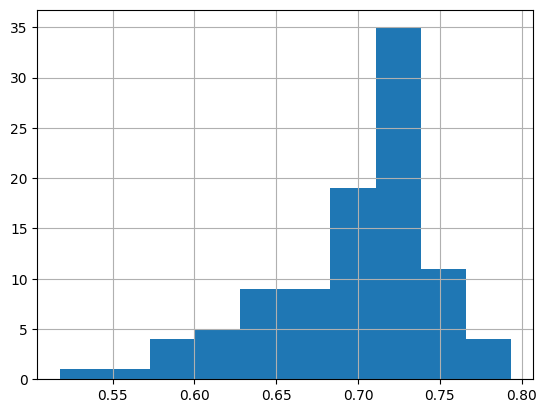

In [ ]:
batch_log_df['Highest Visual Similarity'].hist()

In [ ]:
batch_log_df['New_Example_Visual_Similarity'] = pd.to_numeric(batch_log_df['New_Example_Visual_Similarity'], errors='coerce')

<Axes: >

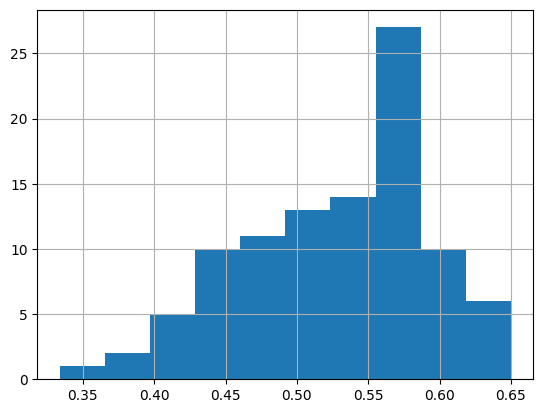

In [ ]:
batch_log_df['New_Example_Visual_Similarity'].hist()

In [ ]:
# Save to a CSV
batch_log_df.to_csv("batch_log.csv", index=False)

## Find local winners

In [ ]:
import cv2
import numpy as np

def calculate_histogram(image_path):
    image = cv2.imread(image_path)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def compare_histograms(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)


In [ ]:
import os
from itertools import combinations

# Function to evaluate the similarity between two images
def evaluate_file_similarity(example_file_path, learner_file_path):
    example_hist = calculate_histogram(example_file_path)
    learner_hist = calculate_histogram(learner_file_path)
    similarity = compare_histograms(example_hist, learner_hist)
    return similarity

# Function to find the local winner from a group of images
def find_local_winner(image_group):
    max_similarity = 0
    winner = None

    for img1, img2 in combinations(image_group, 2):
        similarity = evaluate_file_similarity(img1, img2)

        if similarity > max_similarity:
            max_similarity = similarity
            winner = img1  # or img2 depending on your criteria

    return winner

# Function to find the global winner from local winners
def find_global_winner(local_winners):
    return find_local_winner(local_winners)


In [ ]:
def estimate_tournament_runtime(folder_path, group_size):
    # Get the number of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(image_files)

    # Calculate the number of groups
    num_groups = (num_images + group_size - 1) // group_size  # Ceiling division

    # Estimate the number of comparisons for local winners
    local_comparisons = (group_size * (group_size - 1)) // 2
    total_local_comparisons = local_comparisons * num_groups

    # Estimate the number of comparisons for the global winner
    global_comparisons = (num_groups * (num_groups - 1)) // 2

    # Total number of comparisons
    total_comparisons = total_local_comparisons + global_comparisons

    # Estimate the size of one image (use the first image as a sample)
    sample_image_path = os.path.join(folder_path, image_files[0])
    sample_image_size = os.path.getsize(sample_image_path)  # in bytes

    # Estimate total size for all images
    total_size = sample_image_size * num_images  # in bytes

    # Estimate runtime (this is a very rough estimate; actual time can vary)
    # Assume 0.001 second per comparison per 1000 bytes (this is a made-up number for demonstration)
    estimated_time = 0.001 * total_comparisons * (total_size / 1000)  # in seconds

    return estimated_time, num_images, total_comparisons, total_size

# Usage
folder_path = "/content/temp_downloads"
group_size = 50
estimated_time, num_images, total_comparisons, total_size = estimate_tournament_runtime(folder_path, group_size)
print(f"Estimated time: {estimated_time} seconds")
print(f"Number of images: {num_images}")
print(f"Total number of comparisons: {total_comparisons}")
print(f"Total size: {total_size} bytes")



Estimated time: 644859.306 seconds
Number of images: 375
Total number of comparisons: 9828
Total size: 65614500 bytes


In [ ]:
# List all image files in the folder
all_image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
group_size = 15  # or any other number depending on your needs

# Step 1: Divide into groups
image_groups = [all_image_paths[i:i + group_size] for i in range(0, len(all_image_paths), group_size)]

# Step 2: Find local winners (can be parallelized)
local_winners = [find_local_winner(group) for group in image_groups]

# Step 3: Find global winner
global_winner = find_global_winner(local_winners)

print(f"The most visually similar image is: {global_winner}")


error: ignored

## Cleaning final_log_df

In [ ]:
# Assuming you want to keep the "_x" columns and drop the "_y" columns
cols_to_keep = [col for col in final_log_df.columns if not col.endswith('_y')]

# Remove "_x" suffix from column names
final_log_df = final_log_df[cols_to_keep]
final_log_df.columns = [col.replace('_x', '') for col in cols_to_keep]


In [ ]:
# Dropping all columns ending with "_y"
cols_to_drop = [col for col in final_log_df.columns if col.endswith('_y')]
final_log_df.drop(columns=cols_to_drop, inplace=True)

# Removing "_x" suffix from column names
final_log_df.columns = [col.replace('_x', '') for col in final_log_df.columns]


<ipython-input-115-365e9ef5738b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_log_df.drop(columns=cols_to_drop, inplace=True)


In [ ]:
final_log_df.drop(columns='New_Example_Visual_Similarity', inplace=True)
final_log_df

<ipython-input-119-013b2a0d93de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_log_df.drop(columns='New_Example_Visual_Similarity', inplace=True)


,Learner ID,File Name,Status,Highest Visual Similarity,File Names_Business Communication,URLs_Business Communication
0,Emmanuel Adewumi - emmanueladewumig@gmail.com,biz com2.PNG,Success,0.733927,[biz com2.PNG],https://v5.airtableusercontent.com/v1/21/21/16...
1,Adekunle Awotunde - awotundeaadekunle@gmail.com,Screenshot_20231002-192413~2.png,Success,0.729851,[Screenshot_20231002-192413~2.png],https://v5.airtableusercontent.com/v1/21/21/16...
2,Taiwo Elijah - sanni.taiwo100@gmail.com,Screenshot 998.png,Success,0.693046,[Screenshot 998.png],https://v5.airtableusercontent.com/v1/21/21/16...
3,Jamiu Muraina - imuran4all@gmail.com,Business Communication.docx,Failed - Unsupported file format: .docx. Manua...,NaN,"[Business Communication.docx, Business Communi...",https://v5.airtableusercontent.com/v1/21/21/16...
4,Jamiu Muraina - imuran4all@gmail.com,Business Communication.jpeg,Failed - Unsupported file format: .docx. Manua...,NaN,"[Business Communication.docx, Business Communi...",https://v5.airtableusercontent.com/v1/21/21/16...
...,...,...,...,...,...,...
3355,Michael Uzowuihe - michaeluzowuihe@gmail.com,Business Communication.JPG,Success,0.735672,[Business Communication.JPG],https://v5.airtableusercontent.com/v1/21/21/16...
3356,Daniel Agwu - dagwu036@gmail.com,Completion.PNG,Success,0.703595,[Completion.PNG],https://v5.airtableusercontent.com/v1/21/21/16...
3357,Samuel Adebayo - adebayosamueladeyemi@gmail.com,Screenshot_20231005_183159_Samsung Internet.jpg,Success,0.639524,[Screenshot_20231005_183159_Samsung Internet.jpg],https://v5.airtableusercontent.com/v1/21/21/16...
3358,Jardin Egwa - egwajardin@gmail.com,Business communication.png,Success,0.768621,[Business communication.png],https://v5.airtableusercontent.com/v1/21/21/16...


## Manually check visual similarity of two files

In [ ]:
# Replace these paths with the actual file paths
new_example_cert_path = "new_example_cert.png"
learner_cert_path = "/content/temp_downloads/Ajibade_Business_Communication.PNG"

# Manually evaluate file similarity
similarity_score = evaluate_file_similarity(new_example_cert_path, learner_cert_path)

print(f"The visual similarity score between the two files is: {similarity_score}")


The visual similarity score between the two files is: 0.6956395914112641


## OLD

In [ ]:
# OLD Main Function

if __name__ == "__main__":

    columns_to_process = [
        'Boost Your Career with SAP Skills My Learning screenshot',
        'Learn how to learn (Google)',
        'Business Communication (Google)',
        'Communicate your ideas through storytelling and design (Google)',
        'Get started with Microsoft Teams',
        'Tech for Good: The Role of ICT in Achieving the SDGs'
    ]

    for idx, row in df_learners_selected.iterrows():

        if idx == 30:
            break

        learner_id = row['Learner ID']

        for certificate_column in columns_to_process:

            cert_data_list = row[certificate_column]

            # Ensure it is a list, if not continue to next iteration
            if not isinstance(cert_data_list, list):
                continue

            for file_name in cert_data_list:
                file_path = os.path.join(attachments_dir, file_name)

                example_cert_paths = cert_name_to_example_paths.get(certificate_column, [])

                for example_cert_path in example_cert_paths:

                    cache_key = f"{file_path}-{example_cert_path}"

                    visual_similarity, text_similarity, learner_id_similarity, cache_df = fetch_cached_similarity(
                        cache_df, cache_key, example_cert_path, file_path, learner_id)

                    new_row = pd.DataFrame({
                        'Learner ID': [learner_id],
                        'Certificate Type': [certificate_column],
                        'File Name': [file_name],
                        'Status': ['Success'],
                        'Highest Visual Similarity': [visual_similarity],
                        'Text Similarity Score': [text_similarity],
                        'Learner ID Similarity Score': [learner_id_similarity]
                    })
                    log_df = pd.concat([log_df, new_row], ignore_index=True)

FileNotFoundError: ignored

In [ ]:
# Main Function or Script OLD

# Initialize an empty DataFrame for logging results and errors
log_df = pd.DataFrame(columns=['Learner ID', 'File Name', 'Status', 'Highest Visual Similarity'])

if __name__ == "__main__":

    # Define a batch size
    batch_size = 50  # Change this value based on your requirements

    # Calculate the number of batches
    num_batches = len(df_learners_selected) // batch_size + (len(df_learners_selected) % batch_size != 0)

    # Initialize log DataFrame
    log_df = pd.DataFrame(columns=['Learner ID', 'File Name', 'Status', 'Highest Visual Similarity','Template Match'])

    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = (batch_num + 1) * batch_size
        batch_df = df_learners_selected.iloc[start_idx:end_idx]

    for idx, row in df_learners_selected.iterrows():
        learner_id = row['Learner ID']
        file_names = row['File Names_Business Communication']
        urls = row['URLs_Business Communication']
        downloaded_files = []

        # Create the directory if it doesn't exist
        download_folder = 'temp_downloads'
        if not os.path.exists(download_folder):
            os.makedirs(download_folder)

        for file_name, url in zip(file_names, urls):
            temp_file_path = os.path.join(download_folder, file_name)

            if download_files:
                # Download the file only if download_files flag is True
                download_file(url, temp_file_path)

            try:
                if os.path.exists(temp_file_path):
                    downloaded_files.append(temp_file_path)
                   # Evaluate similarity
                    visual_similarity, template_matching_score = evaluate_file_similarity('example_cert.pdf', temp_file_path, template_cert_image) ## define example cert variable

                    # You can now log or further process the results
                    highest_similarity = max(similarity_scores.values())

                    # Log success
                    new_row = pd.DataFrame({
                        'Learner ID': [learner_id],
                        'File Name': [file_name],
                        'Status': ['Success'],
                        'Highest Visual Similarity': [highest_similarity],
                        'Template Match': [template_matching_score]
                    })
                    log_df = pd.concat([log_df, new_row], ignore_index=True)

            except Exception as e:
                # Log the exception
                new_row = pd.DataFrame({
                    'Learner ID': [learner_id],
                    'File Name': [file_name],
                    'Status': [f'Failed - {str(e)}'],
                    'Highest Visual Similarity': [None]
                })
                log_df = pd.concat([log_df, new_row], ignore_index=True)

    # Save log_df to a CSV
    log_df.to_csv("log.csv", index=False)


## OLD

In [ ]:
# OLD Main Function

if __name__ == "__main__":

    # Initialize an empty list to hold errors for logging later
    error_logs = []

    columns_to_process = [
        'Boost Your Career with SAP Skills My Learning screenshot',
        'Learn how to learn (Google)',
        'Business Communication (Google)',
        'Communicate your ideas through storytelling and design (Google)',
        'Get started with Microsoft Teams',
        'Tech for Good: The Role of ICT in Achieving the SDGs'
    ]

for idx, row in df_learners_selected.iterrows():

        if idx == 10:
            break

        learner_id = row['Learner ID']

        for certificate_column in columns_to_process:

            cert_data_list = row[certificate_column]

            # Ensure it is a list, if not continue to next iteration
            if not isinstance(cert_data_list, list):
                continue

            for file_name in cert_data_list:
                # Updated line here to include course name
                file_path = os.path.join(attachments_dir, certificate_column, file_name)

                example_cert_paths = cert_name_to_example_paths.get(certificate_column, [])

                for example_cert_path in example_cert_paths:

                    try:
                        # Your existing code that may throw a FileNotFoundError
                        cache_key = f"{file_path}-{example_cert_path}"
                        visual_similarity, text_similarity, learner_id_similarity, cache_df = fetch_cached_similarity(
                            cache_df, cache_key, example_cert_path, file_path, learner_id)

                        new_row = pd.DataFrame({
                            'Learner ID': [learner_id],
                            'Certificate Type': [certificate_column],
                            'File Name': [file_name],
                            'Status': ['Success'],
                            'Highest Visual Similarity': [visual_similarity],
                            'Text Similarity Score': [text_similarity],
                            'Learner ID Similarity Score': [learner_id_similarity]
                        })
                        log_df = pd.concat([log_df, new_row], ignore_index=True)

                    except FileNotFoundError:
                        error_msg = f"File not found: {file_path} or {example_cert_path}"
                        print(error_msg)
                        error_logs.append(error_msg)
                        continue
                    except Exception as e:  # New block to catch other exceptions
                        error_msg = f"An exception occurred: {e}"
                        print(error_msg)
                        error_logs.append(error_msg)
                        continue

                # Print or save error_logs as needed
                if error_logs:
                    print("The following errors were encountered:")
                    for error in error_logs:
                        print(error)

File not found: /content/drive/MyDrive/Colab Notebooks/Certificate confirmer data/attachments/Get started with Microsoft Teams/Transcript.pdf or /content/example_certs/Get started with Microsoft Teams/example_certificate_Teams1.pdf
The following errors were encountered:
File not found: /content/drive/MyDrive/Colab Notebooks/Certificate confirmer data/attachments/Get started with Microsoft Teams/Transcript.pdf or /content/example_certs/Get started with Microsoft Teams/example_certificate_Teams1.pdf
The following errors were encountered:
File not found: /content/drive/MyDrive/Colab Notebooks/Certificate confirmer data/attachments/Get started with Microsoft Teams/Transcript.pdf or /content/example_certs/Get started with Microsoft Teams/example_certificate_Teams1.pdf
The following errors were encountered:
File not found: /content/drive/MyDrive/Colab Notebooks/Certificate confirmer data/attachments/Get started with Microsoft Teams/Transcript.pdf or /content/example_certs/Get started with Mi

KeyboardInterrupt: ignored

In [ ]:
# Old Main Fuinction with caching

# Initialize an empty DataFrame for logging results and errors
log_df = pd.DataFrame(columns=['Learner ID',
                               'Certificate Type',
                               'File Name',
                               'Status',
                               'Highest Visual Similarity',
                               'Text Similarity Score',
                               'Learner ID Similarity Score'
                               ])

# Initialize a DataFrame for caching
cache_df = pd.DataFrame(columns=['Cache Key', 'Visual Similarity', 'Text Similarity', 'Learner ID Similarity'])

if __name__ == "__main__":

    for idx, row in df_learners_selected.iterrows():

        if idx == 30:  # Stop after processing 30 rows
            break

        learner_id = row['Learner ID']

        for certificate_column in certificate_names:

            cert_data = row[certificate_column]
            if pd.isna(cert_data):  # Skip if this cell is NaN
                continue

            file_name = extract_file_name(cert_data)  # Assuming this function is defined elsewhere
            file_path = os.path.join(attachments_dir, file_name)

            example_cert_paths = cert_name_to_example_paths.get(certificate_column, [])
            if not example_cert_paths:
                continue

            for example_cert_path in example_cert_paths:

                cache_key = f"{file_path}-{example_cert_path}"

                cached_row = cache_df[cache_df['Cache Key'] == cache_key]

                if cached_row.empty:
                    visual_similarity = evaluate_file_similarity(example_cert_path, file_path)
                    text_similarity = calculate_text_similarity(example_cert_path, file_path)
                    learner_id_similarity = calculate_learner_id_similarity(learner_id, file_path)

                    new_cache_row = pd.DataFrame({
                        'Cache Key': [cache_key],
                        'Visual Similarity': [visual_similarity],
                        'Text Similarity': [text_similarity],
                        'Learner ID Similarity': [learner_id_similarity]
                    })
                    cache_df = pd.concat([cache_df, new_cache_row], ignore_index=True)

                else:
                    visual_similarity = cached_row['Visual Similarity'].iloc[0]
                    text_similarity = cached_row['Text Similarity'].iloc[0]
                    learner_id_similarity = cached_row['Learner ID Similarity'].iloc[0]

                try:
                    visual_similarity = evaluate_file_similarity(example_cert_path, file_path)
                    text_similarity = calculate_text_similarity(example_cert_path, file_path)
                    learner_id_similarity = calculate_learner_id_similarity(learner_id, file_path)

                    new_row = pd.DataFrame({
                        'Learner ID': [learner_id],
                        'Certificate Type': [certificate_column],
                        'File Name': [file_name],
                        'Status': ['Success'],
                        'Highest Visual Similarity': [visual_similarity],
                        'Text Similarity Score': [text_similarity],
                        'Learner ID Similarity Score': [learner_id_similarity]
                    })
                    log_df = pd.concat([log_df, new_row], ignore_index=True)

                except Exception as e:
                    new_row = pd.DataFrame({
                        'Learner ID': [learner_id],
                        'Certificate Type': [certificate_column],
                        'File Name': [file_name],
                        'Status': [f'Failed - {str(e)}'],
                        'Highest Visual Similarity': [None],
                        'Text Similarity Score': [0],
                        'Learner ID Similarity Score': [0]
                    })
                    log_df = pd.concat([log_df, new_row], ignore_index=True)

    log_df.to_csv("log.csv", index=False)


NameError: ignored

In [ ]:
# Old Main Function

# Initialize an empty DataFrame for logging results and errors
log_df = pd.DataFrame(columns=['Learner ID',
                               'Certificate Type',
                               'File Name',
                               'Status',
                               'Highest Visual Similarity',
                               'Text Similarity Score',
                               'Learner ID Similarity Score'
                               ])

if __name__ == "__main__":

    for idx, row in df_learners_selected.iterrows():

        # Break the loop after processing 30 rows
        if idx == 30:
            break

        learner_id = row['Learner ID']
        certificate_columns = certificate_names

        for certificate_column in certificate_columns:
            cert_data = row[certificate_column]
            if pd.isna(cert_data):  # Skip if this cell is NaN
                continue

            # Split the cell data into file names and URLs (Assuming function returns these)
            file_name, url = split_file_url_complex(cert_data)

            # Additional code logic for downloading, folder creation etc.
            # ...

            try:
                # Initialize max_similarity values
                max_visual_similarity = 0
                max_text_similarity = 0
                max_learner_id_similarity = 0

                # Create the directory if it doesn't exist
                download_folder = 'temp_downloads'
                if not os.path.exists(download_folder):
                    os.makedirs(download_folder)

                # Define the path where the file will be downloaded
                temp_file_path = os.path.join(download_folder, file_name)

                # Download the file
                download_file(url, temp_file_path)  # Assuming you have a function 'download_file' that takes a URL and a file path

                # Check if the example certificate path exists
                example_cert_path = cert_name_to_example_path.get(certificate_column, None)
                if example_cert_path is None:
                    continue  # Skip this iteration if we don't have an example

                # Log success with max_similarity values
                new_row = pd.DataFrame({
                    'Learner ID': [learner_id],
                    'Certificate Type': [certificate_column],
                    'File Name': [file_name],
                    'Status': ['Success'],
                    'Highest Visual Similarity': [max_visual_similarity],
                    'Text Similarity Score': [max_text_similarity],
                    'Learner ID Similarity Score': [max_learner_id_similarity]
                })
                log_df = pd.concat([log_df, new_row], ignore_index=True)

            except Exception as e:
                # Log the exception
                new_row = pd.DataFrame({
                    'Learner ID': [learner_id],
                    'Certificate Type': [certificate_column],
                    'File Name': [file_name],
                    'Status': [f'Failed - {str(e)}'],
                    'Highest Visual Similarity': [None],
                    'Text Similarity Score': [0],
                    'Learner ID Similarity Score': [0]
                })
                log_df = pd.concat([log_df, new_row], ignore_index=True)

        # Save log_df to a CSV after each learner for safety
        log_df.to_csv("log.csv", index=False)


In [ ]:
# Older Main Function or Script

# Initialize an empty DataFrame for logging results and errors
log_df = pd.DataFrame(columns=['Learner ID',
                               'Certificate Type',
                               'File Name',
                               'Status',
                               'Highest Visual Similarity',
                               'Text Similarity Score',
                               'Learner ID Similarity Score'
                               ])

if __name__ == "__main__":

    # Define a batch size
    batch_size = 20  # Changed batch size to 20 for the test run

    # Calculate the number of batches
    num_batches = len(df_learners_selected) // batch_size + (len(df_learners_selected) % batch_size != 0)

    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = (batch_num + 1) * batch_size
        batch_df = df_learners_selected.iloc[start_idx:end_idx]

        # Added a break to run only the first batch as a test
        if batch_num == 50:
            break

        for certificate_name in certificate_names:
            col_file_names = f'File Names_{certificate_name}'
            col_urls = f'URLs_{certificate_name}'

            df_learners_selected[[col_file_names, col_urls]] = df_learners_selected[certificate_name].apply(split_file_url_complex)

            for idx, row in batch_df.iterrows():
                learner_id = row['Learner ID']
                cert_names = row['Certificate Names']  # This should contain the list of certificates for the learner
                file_names = row[col_file_names]
                urls = row[col_urls]
                downloaded_files = []

                # Create the directory if it doesn't exist
                download_folder = 'temp_downloads'
                if not os.path.exists(download_folder):
                    os.makedirs(download_folder)

                for cert_name, file_name, url in zip(cert_names, file_names, urls):
                    temp_file_path = os.path.join(download_folder, file_name)

                    if download_files:
                        # Download the file only if download_files flag is True
                        download_file(url, temp_file_path)

                    # Get the corresponding example certificate path using the mapping
                    example_cert_path = cert_name_to_example_path.get(cert_name, None)
                    if example_cert_path is None:
                        continue  # Skip this iteration if we don't have an example cert for this certificate name


                    try:
                        if os.path.exists(temp_file_path):
                            downloaded_files.append(temp_file_path)

                            # Loop through all example paths for this certificate type
                            for example_cert_path in cert_name_to_example_paths.get(cert_name, []):

                              # Evaluate visual similarity
                              visual_similarity = evaluate_file_similarity(example_cert_path, temp_file_path) ## define example cert variable

                              # Extract text from the downloaded file
                              extracted_text = extract_text_from_file(temp_file_path)

                              # Compute text similarity to key phrases
                              text_similarity_score = calculate_text_similarity_key_phrases(key_phrases, extracted_text)

                              # Compute Learner ID similarity
                              learner_id_similarity_score = calculate_learner_id_similarity(extracted_text, learner_id)

                            # Log success
                            new_row = pd.DataFrame({
                                'Learner ID': [learner_id],
                                'Certificate Type': [certificate_name],
                                'File Name': [file_name],
                                'Status': ['Success'],
                                'Highest Visual Similarity': [visual_similarity],
                                'Text Similarity Score': [text_similarity_score],
                                'Learner ID Similarity Score': [learner_id_similarity_score]
                            })
                            log_df = pd.concat([log_df, new_row], ignore_index=True)

                    except Exception as e:
                        # Log the exception
                        new_row = pd.DataFrame({
                            'Learner ID': [learner_id],
                            'Certificate Type': [certificate_name],
                            'File Name': [file_name],
                            'Status': [f'Failed - {str(e)}'],
                            'Highest Visual Similarity': [None],
                            'Text Similarity Score': [0],
                            'Learner ID Similarity Score': [0]
                        })
                        log_df = pd.concat([log_df, new_row], ignore_index=True)

    # Save log_df to a CSV
    log_df.to_csv("log.csv", index=False)


KeyError: ignored

In [ ]:
# Old Main Function

# Initialize an empty DataFrame for logging results and errors
log_df = pd.DataFrame(columns=['Learner ID',
                               'Certificate Type',
                               'File Name',
                               'Status',
                               'Highest Visual Similarity',
                               'Text Similarity Score',
                               'Learner ID Similarity Score'
                               ])

# Define the directory where attachments are stored
attachments_dir = '/content/drive/MyDrive/Colab Notebooks/Certificate confirmer data/attachments'

if __name__ == "__main__":

    for idx, row in df_learners_selected.iterrows():

        if idx == 30:  # Stop after processing 30 rows
            break

        learner_id = row['Learner ID']

        for certificate_column in certificate_columns:  # Assuming certificate_columns is defined elsewhere

            cert_data = row[certificate_column]
            if pd.isna(cert_data):  # Skip if this cell is NaN
                continue

            file_name = extract_file_name(cert_data)  # Assuming this function is defined elsewhere
            file_path = os.path.join(attachments_dir, file_name)

            example_cert_paths = cert_name_to_example_paths.get(certificate_column, [])
            if not example_cert_paths:
                continue

            for example_cert_path in example_cert_paths:

                try:
                    visual_similarity = evaluate_file_similarity(example_cert_path, file_path)
                    text_similarity = calculate_text_similarity(example_cert_path, file_path)
                    learner_id_similarity = calculate_learner_id_similarity(learner_id, file_path)

                    new_row = pd.DataFrame({
                        'Learner ID': [learner_id],
                        'Certificate Type': [certificate_column],
                        'File Name': [file_name],
                        'Status': ['Success'],
                        'Highest Visual Similarity': [visual_similarity],
                        'Text Similarity Score': [text_similarity],
                        'Learner ID Similarity Score': [learner_id_similarity]
                    })
                    log_df = pd.concat([log_df, new_row], ignore_index=True)

                except Exception as e:
                    new_row = pd.DataFrame({
                        'Learner ID': [learner_id],
                        'Certificate Type': [certificate_column],
                        'File Name': [file_name],
                        'Status': [f'Failed - {str(e)}'],
                        'Highest Visual Similarity': [None],
                        'Text Similarity Score': [0],
                        'Learner ID Similarity Score': [0]
                    })
                    log_df = pd.concat([log_df, new_row], ignore_index=True)

    log_df.to_csv("log.csv", index=False)
